
# Solving an OLG Model with the [bc-MC Operator](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4476122)


This notebook solves the OLG model presented in  [Krueger and Kubler (2004)](https://www.sciencedirect.com/science/article/pii/S0165188903001118) and [Azinovic, Gaegauf and Scheidegger (2022)](https://onlinelibrary.wiley.com/doi/full/10.1111/iere.12575), based on the work of [Huffman (1987)](https://www.jstor.org/stable/1831303). This notebook was greatly inspired by [this notebook](https://github.com/sischei/DeepEquilibriumNets/blob/master/code/jupyter-notebooks/analytic/Analytic_tf1.ipynb), accompanying the [Deep Equilibrium Nets](https://onlinelibrary.wiley.com/doi/full/10.1111/iere.12575) paper.

### TL;DR

This notebook computes a global approximation to an OLG model using neural networks and the [bc-MC operator](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4476122).

---
---


## I. Theory

### Households
* Agents live for $A$ periods and have a [CRRA utility function](https://en.wikipedia.org/wiki/Isoelastic_utility): $u(c) = \frac{c^{1-\gamma} - 1}{1 - \gamma}$, with $u(c) = \log(c)$ when $\gamma \rightarrow 1$
* Agents only work in the first period of their life: $l^h_t=1$ for $h=0$ and $l^h_t=0$ otherwise. Hence, aggregate labor supply is constant and equal to one: $L_t=1$. 
* Agents receive a competitive wage and can save in risky capital. 
* Households cannot die with debt and they are born with 0 assets.

Households solve the following maximization problem:

$$ \max_{\{c_{t+h}^{h}, a_{t+h}^{h}\}_{h=0}^{A-1}}\mathbb{E}_{t}{\sum_{h=0}^{A-1}u(c_{t+h}^{h})} $$
subject to:
$$c_{t}^{h} + a_t^{h} = r_t k_t^h + w_t l^h_t$$
$$k^{h+1}_{t+1} = a_t^h $$
$$a^{A-1}_t \geq 0$$

where
* $c_t^h$ denotes the consumption of age-group $h$ at time $t$
* $a^h_t$ denotes the saving of age-group $h$ at time $t$
* $k_t^h$ denotes the available capital in the beginning of the period of age-group $h$ at time $t$
* $l_t^h$ denotes the exogenously supplied labor endowment of age-group $h$ at time $t$
* $r_t$ denotes the price of capital
* $w_t$ denotes the wage

### Firms

There is a single representative firm with Cobb-Douglas production function.
The production function is given by
$$f(K_t,L_t,z_t) = \eta_t K^{\alpha}_t L^{1-\alpha}_t + K_t(1-\delta_t),$$
where $K_t$ denotes aggregate capital, with
$$K_t = \sum_{h=0}^{A-1} k^h_t,$$
$L_t$ denotes the aggregate labor supply, with
$$L_t = \sum_{h=0}^{A-1} l^h_t,$$

* $\alpha$ denotes the capital share in production
* $\eta_t$ denotes the stochastic TFP
* $\delta_t$ denotes the stochastic depreciation

The firm's optimization problem implies that the return on capital and the wage are given by
$$r_t = \alpha \eta_t K_t^{\alpha - 1} L_t^{1 - \alpha} + (1 - \delta_t),$$
$$w_t = (1 - \alpha) \eta_t K_t^{\alpha} L_t^{-\alpha}.$$

### Equilibrium

A competitive equilibrium, given initial conditions $z_0, \{ k_0^s \}_{s=0}^{A-1}$, is defined as a collection of choices for households $ \{ (c_t^s, a_t^s)_{s = 0}^{A-1} \}_{t=0}^\infty$ and for the representative firm $(K_t, L_t)_{t=0}^\infty$ as well as prices $(r_t, w_t)_{t=0}^\infty$, such that

1. given prices, households optimize
2. given prices, the firm maximizes profits
3. markets clear

---

### Model calibration 


Unlike [Krueger and Kubler (2004)](https://www.sciencedirect.com/science/article/pii/S0165188903001118) or [Azinovic, Gaegauf and Scheidegger (2022)](https://onlinelibrary.wiley.com/doi/full/10.1111/iere.12575), let's use continuous distributions for shocks. The existence of a closed-form solution does not rely on using discrete shocks. Actually, [Huffman (1987)](https://www.jstor.org/stable/1831303) uses lognormal distributions in his simulations (Table 1 and 2, pages 154).

### Shocks
* $\delta$ is $\mathcal{N}(\mu_{\delta}, \sigma_{\delta}^2)$ 
* $\eta$ is $\mathcal{N}(\mu_{\eta},  \sigma_{\eta}^2)$

To align with the paper, we can work with the centered variables
* $\tilde{\delta}$ is $\mathcal{N}(0.0, \sigma_{\delta}^2)$ 
* $\tilde{\eta}$ is $\mathcal{N}(0.0, \sigma_{\eta}^2)$

with $\delta = \mu_{\delta} + \tilde{\delta}$ and $\eta = \mu_{\eta} + \tilde{\eta}$.
The **innovation vector** is given by $\varepsilon = (\tilde{\delta}, \tilde{\eta})$

### Parametrization
* Cobb-Douglas production function with $\alpha = 0.3$
* Discount factor of agents $\beta=0.7$
* Log utility: $\gamma = 1.0$

### Euler equation

For an age-group $h$, the optimal consumption function $c^{h}$ is such that:

$$u^{\prime}(c^{h}_t) =  \mathbf{E}_{\varepsilon}\big[{\beta u^{\prime}(c^{h}_{t+1}) r_{t+1}} \big]$$
 
$$(c^{h}_t)^{-\gamma} =  \mathbf{E}_{\varepsilon}\big[{\beta (c^{h}_{t+1})^{-\gamma} r_{t+1}} \big]$$
 

When using log utility ($\gamma = 1$):

$$ 0 =  \mathbf{E}_{\varepsilon}\big[{\beta \frac{c^{h}_{t}}{c^{h}_{t+1}} r_{t+1}} \big] - 1$$


### Solving the model with the [bc-MC operator](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4476122)

Let's use a neural network to calculate an approximation of the consumption function. 
* The neural network has for input the distribution of total wealth (labor + financial income): $\text{wealth}^h_t = r_t k_t^h + w_t l^h_t$. 
* The neural network outputs the share of total income that is consumed: $\phi^h_t = \mathcal{NN}(\text{wealth}^h_t | \theta)$, where $\theta$ is the neural network's parameter vector (biases and weights). Hence, consumption is given by $c^h_t = \phi^h_t \times \text{wealth}^h_t$. 
* From the budget constraint, we can directly recover the saving decisions: $a^h_t = \text{wealth}^h_t - c^h_t = (1 - \phi^h_t)\text{wealth}^h_t$. We impose that the last generation consumes their total wealth: $\phi^{A-1}_t = 1$.

Let's consider a single age group $h$. We want to find the value for $\theta$ such that the Euler equation holds. For "good" values of $\theta$, the Euler equation must hold, meaning that the following quantity should be extremely close to 0:

$$ \Big(\mathbf{E}_{\varepsilon}\big[{\beta \frac{c^{h}_{t}}{c^{h}_{t+1}} r^{\prime}} \big] - 1 \Big)^2$$

The relevant state vector $s$ is the beginning-of-period distribution of capital $(k_t^0, k_t^1, ...,k_t^{A-1})$. We want the Euler equation to hold not for just one value of $s$, but ideally for all values of $s$. One way to capture that this idea is to work with the expectation over the state vector s:
$$ \mathbf{E}_{s}\Big[ \Big(\mathbf{E}_{\varepsilon}\big[{\beta \frac{c^{h}_{t}}{c^{h}_{t+1}} r^{\prime}} \big] - 1 \Big)^2 \Big] $$

Let's use Monte-Carlo to approximate both expectations. We will be using $M$ independent draws for $s$ and $N$ independent draws for $\varepsilon$, each value of $s$. Let's also use minimum-variance unbiased estimator (MVUE) for the square of the mean. This leads to the following loss function (see the [paper](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4476122)):

$$ \mathcal{L} = \frac{1}{M}\frac{2}{N(N-1)} \sum_{m=1}^{M} \sum^{N}_{1 \leq i < j} f^h(s_m, \varepsilon^i_m)f^h(s_m, \varepsilon^j_m)$$

with $f^h(s_m, \varepsilon^i_m) = \beta \frac{c^{h}_{t}}{c^{h}_{t+1}} r^{\prime} - 1$, and where $\mathcal{L}$ depends on the neural net's parameter vector $\theta$, as well as on the values of the state and innovation vectors.

### Vectorization
#### Vectorization for one age category
For efficiency reasons, the above code can be vectorized. For a single age group $h$, the loss function can be calculated as

$$\mathcal{L}^h = \frac{1}{M}\frac{2}{N(N-1)} (f^{h})^{T} \Lambda f^{h}$$

with  $(f^{h})^{T} = \big(f^h(s_1, \varepsilon^1_1), f^h(s_1, \varepsilon^2_1), ..., f^h(s_1, \varepsilon^N_1), ...., f^h(s_M, \varepsilon^{1}_M), ..., f^h(s_M, \varepsilon^{N-1}_M), f^h(s_M, \varepsilon^N_M)\big)$ a $1 \times MN$ row vector and

$$ \Lambda = \mathbb{I}_M \otimes \mathbb{U}_N $$ a sparse $MN \times MN$ matrix, where $\mathbb{I}_M$ is the identity matrix of size $M \times M$ and $\mathbb{U}_N$ is a $N \times N$ upper trianguler matrix whose diagonal elements are all equal to zero, while the entries above the main diagonal are equal to one. For instance, if $M=2$ and $N=2$:

$$\mathbb{I}_M = \begin{pmatrix}
1 & 0 \\
0 & 1 
\end{pmatrix}$$

$$\mathbb{U}_N = \begin{pmatrix}
0 & 1 \\
0 & 0 
\end{pmatrix}$$

$$ \Lambda = \begin{pmatrix}
0 & 1 & 0 & 0\\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 \\
0 & 0 & 0 & 0
\end{pmatrix} $$



#### Vectorization for several age categories
Now, we have $A-1$ Euler conditions. We can take a weighted sum (average) of the $A-1$ Euler conditions:

$$\mathcal{L} = \frac{1}{A-1} \mathcal{L}^0 + ... + \frac{1}{A-1} \mathcal{L}^{A-2}$$

which we can calculate using

$$\mathcal{L} = \frac{1}{A-1}\frac{1}{M}\frac{2}{N(N-1)} (f)^{T} \Sigma f$$

where $\Big((f^{0})^{T}, (f^{1})^{T}, ..., (f^{A-2})^{T} \big)$ a $1 \times (A-1)MN$ row vector and 

$$ \Sigma = \mathbb{I}_{A-1} \otimes \Lambda = \begin{pmatrix}
\Lambda & \mathbf{0} & ... & \mathbf{0}\\
\mathbf{0} & \Lambda & \mathbf{0} & \mathbf{0} \\
... & \mathbf{0} & ... & ... \\
\mathbf{0} & \mathbf{0} & ... & \Lambda
\end{pmatrix} $$

a sparse $(A-1)MN \times (A-1)MN$ matrix. 

### Closed-form solution
This model has a closed-form solution. For a given age group, agents consume a fixed fraction of their total wealth (labor income + capital income):
\begin{align}
\mathbf{a}^{\text{true}}_t=
\beta
\begin{bmatrix}
\frac{1-\beta^{A-1}}{1-\beta^{A}} w_t \\
\frac{1-\beta^{A-2}}{1-\beta^{A-1}} r_t k^{1}_t \\
\frac{1-\beta^{A-3}}{1-\beta^{A-2}} r_t k^{2}_t \\
\dots \\
\frac{1-\beta^{1}}{1-\beta^2} r_t k^{A-2}_t \\
\end{bmatrix}.
\end{align}

### Unit-less Euler equation error

$$ \mathcal{E}(s) =  \frac{1}{c_t}(u^{\prime-1})\Big(\mathbf{E}_{\varepsilon}\big[{\beta u^{\prime}(c_{t+1}) r_{t+1}} \big]\Big) - 1$$

I calculate the mean Euler equation error, denoted by $\mathbf{E}(\mathcal{E}(s))$, using Monte Carlo or Gaussian quadrature to approximate $\mathbf{E}_{\varepsilon}$ (see the notebook `functions_OLG.ipynb`). However, as explained in the [paper](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4476122), we can use the value of the loss $\mathcal{L}$ to approximate $\mathbf{E}(\mathcal{E}(s))$.

Using our CRRA utility function, we have 

\begin{equation} 
\begin{split}
\mathcal{E}(s) & =  \frac{1}{c_t}\Big(\mathbf{E}_{\varepsilon}\big[{\beta (c_{t+1})^{-\gamma} r_{t+1}} \big]\Big)^{\frac{-1}{\gamma}} - 1 \\
 & =  \Big(\mathbf{E}_{\varepsilon}\big[{\beta (\frac{c_{t+1}}{c_t})^{-\gamma} r_{t+1}} \big]\Big)^{\frac{-1}{\gamma}} - 1 \\
\end{split}
\end{equation}
 
Using $x^{\alpha} \approx 1 + \alpha(x-1)$ for $x \approx 1$:

\begin{equation} 
\mathcal{E}(s) \approx  \frac{-1}{\gamma}\Big(\mathbf{E}_{\varepsilon}\big[{\beta (\frac{c_{t+1}}{c_t})^{-\gamma} r_{t+1}} \big] - 1 \Big)
\end{equation}

The square of $\mathcal{E}(s)$ is approximately equal to 
\begin{equation} 
\mathcal{E}(s)^2 \approx  \frac{1}{\gamma^2}\Big(\mathbf{E}_{\varepsilon}\big[{\beta (\frac{c_{t+1}}{c_t})^{-\gamma} r_{t+1}} \big] - 1\Big)^2
\end{equation}

Hence, 
\begin{equation} 
\begin{split}
\mathbf{E} \Big[ \mathcal{E}(s)^2 \Big]^{0.5} & \approx  \frac{1}{\gamma} \mathbf{E}_{s}\Big[ \Big(\mathbf{E}_{\varepsilon}\big[{\beta (\frac{c_{t+1}}{c_t})^{-\gamma} r_{t+1}} \big] - 1\Big)^2 \Big]^{0.5} \\
& \approx \frac{1}{\gamma} \mathcal{L}^{0.5}
\end{split} 
\end{equation}

---

## II. Computations


### Roadmap

<div style="background-color: #f0f0f0; padding: 10px;">    
    
#### II. A. Load Libraries, Functions, and Types

#### II. B. Neural Net Architecture
- Set up the neural network.

#### II. C. bc-MC Operator
- Define functions for the bc-MC operator.

#### II. D. Solve Model Drawing from the True Ergodic Distribution
- Assume we can draw from the ergodic distribution.

#### II. E. Jointly Solve for Policy Functions and Ergodic Distribution
- Learn the ergodic distribution and the solution of the economic model.

#### II. F. Optimal Selection of N While Jointly Solving for Policy Functions and the Ergodic Distribution
- Learn the ergodic distribution and the solution of the economic model, with optimal choice for N.

#### II. G. Optimal Selection of N, No Analytical Solution
- When ($\gamma \neq 1\$), learn the ergodic distribution and the solution of the economic model, with optimal choice for N.

#### II. H. Large Scale: Optimal Selection of N
- Same as Section II. F, but with **60 age categories** instead of 6.


</div>

### II. A. Load libraries, functions and types

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import random
import scipy.stats
import chaospy  ## for quadrature
from itertools import product
import os

import time
import os
import pandas as pd
import numpy as np
from math import sqrt
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()
from tqdm import tqdm as tqdm
import datetime
from typing import Tuple
class Vector: pass
from scipy.stats import norm
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset, Dataset
# To create copies of NN
import copy
import matplotlib.ticker as mtick
# To use sparse kronecker product
from scipy import sparse
from torchcontrib.optim import SWA
from torch.nn.utils import clip_grad_norm_
import itertools
# Interpolations
from scipy.interpolate import LinearNDInterpolator
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.interpolate import RegularGridInterpolator

# Regressions
import statsmodels.formula.api as smf
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

import quantecon as qe
from interpolation import interp
from quantecon.optimize import brentq
from numba import njit, float64
from numba.experimental import jitclass
#import copy # Not used so far

import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import MaxNLocator

import platform,socket,re,uuid,json,psutil,logging, cpuinfo, shutil

import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset

In [2]:
# Store parameters
class MyParams():
    """
    N: number of draws for innovation vector
    M: number of draws for the state vector
    lr: learning rate
    nb_epochs: number of gradient descent steps during training
    """
    def __init__(self, N, M, lr, optimizer, nb_epochs, order_gauss, nb_agents, 
                 beta, alpha, std_tfp, std_delta, gamma):
        # Model parameters
        self.beta = beta # Discount factor (patience)
        self.alpha = alpha # Capital share in production
        self.gamma = gamma # CRRA coefficient
        self.one_min_gamma = 1 - self.gamma
        # Nb agents:
        self.nb_agents = nb_agents
        self.nb_shocks = 2
        ## State: aggregate capital, distribution of wealth + 2 shocks (they don't matter here, no serial correlation)
        self.dim_state = self.nb_agents + 2
        ## Input for neural net
        self.dim_input = self.dim_state - 2 #Don't need to include shocks into neural net (no serial correlation)
        self.dim_output = self.nb_agents - 1 #share of wealth consumed (last generation consume everything)
        # Standard deviation exo random variables
        self.std_tfp = std_tfp #0.05 
        self.std_delta = std_delta #0.01
        # Mean value exo random variables
        self.mean_tfp = 1.0
        self.mean_delta = 0.10
        # Functions
        ## Utility
        if self.gamma != 1:
            self.u = lambda c: (1/self.one_min_gamma)*(c**(self.one_min_gamma) - 1)
        else:
            self.u = lambda c: torch.log(c)
        self.u_prime =  lambda c: c**(-self.gamma)
        self.u_prime_inv =  lambda c: c**(-(1/self.gamma))
        # bc-MC hyperparameters
        self.N = N #number of iid shocks used for each value of the state vector
        self.M = M #number of iid realization of the state vector
        self.MN = int(M*N)
        # To keep constant the number of function evaluations
        self.T = int((M*N)/2) #number 
        self.distribution_shocks = "Normal" #"Normal" #Lognormal
        # Vectorized bc-MC
        # W used using the 2/M*N*(N-1) Sum f(i)*f(j) formula
        self.W_single_age_group = create_W_expanded_matrix(self.M, self.N, 1)
        # Expand W to vectorize calculations for all age groups:
        self.W_expanded = create_W_expanded_matrix(self.M, self.N, self.nb_agents-1)
        # Learning parameters
        self.lr = lr
        self.momentum = 0.9 #momentum for SGD with momentum
        self.optimizer = optimizer #"Adam" #default: #Adam or SGD or SWA
        self.freq_gamma = 0.95 #When using a scheduler for the learning rate, lr_{t} = freq_gamma*lr_{t-1}
        self.use_scheduler = False #If true, use a scheduler for the learning rate
        self.nb_epochs = nb_epochs
        self.freq_scheduler = 1000 
        # GAUSSIAN QUADRATURE
        strr = "chaospy.Normal(self.mean_tfp, self.std_tfp), chaospy.Normal(self.mean_delta, self.std_delta)"
        self.distrib = eval('chaospy.J({})'.format(strr))
        self.order_gauss = order_gauss
        nodes, weights = dist(self.order_gauss, self.distrib, rule = "gaussian", sp=True)
        self.nodes = nodes
        self.weights = weights
        self.weights_torch = torch.tensor(weights)
        self.nodes_torch = torch.tensor(np.transpose(self.nodes)) #column=dim. Row=observation
        # Save the number of points for the guassian quadrature:
        self.N_gaussian = len(self.weights_torch)
        # Implied number of points for the current space (T=MN/2 <-> M = 2T/N)
        self.M_gaussian = int((2*self.T)/self.N_gaussian)
        self.MN_gaussian = self.N_gaussian*self.M_gaussian
        # Repeat nodes to match the number of function evaluations for the expectation
        self.nodes_torch_repeated = self.nodes_torch.repeat(self.M_gaussian, 1)
        # Check bad combination
        if (self.optimizer == "SWA") & (self.use_scheduler == True):
            raise('opt SWA and use_schedule = True')
        # True solution
        exponent_1 = self.nb_agents - 1 - torch.arange(self.nb_agents-1)
        exponent_2 = self.nb_agents - torch.arange(self.nb_agents-1)
        mult_wealth =  self.beta*(1 - self.beta**exponent_1)/(1 - self.beta**exponent_2)
        # saving decision given by wealth*mult_wealth
        self.mult_wealth = torch.cat((mult_wealth, torch.tensor([0.0]))) #last generation does not save


In [3]:
# Load functions
%run functions_OLG.ipynb

plot_scale = 0.75
plt.rcParams["figure.figsize"] = (plot_scale*16, plot_scale*9)
# Controlling fontsizes
SMALL_SIZE = 12
MEDIUM_SIZE = SMALL_SIZE + 2
BIGGER_SIZE =  SMALL_SIZE + 4
plt.rcParams['legend.fontsize'] = MEDIUM_SIZE
dpi_chosen=600 #control the quality of .png
linewidth_chosen = 2

Using cpu device


In [4]:
M_chosen = 100 #Nb draws state vector
N_chosen = 2 #Nb draws innovation vector for each realization of the state vector
lr_chosen = 1e-3 #Learning rate
nb_epochs_chosen = 2000
order_gauss_chosen = 3
optimizer_chosen = "Adam"
nb_agents_chosen = 6
beta_chosen = 0.7
alpha_chosen = 0.3
std_tfp_chosen = 0.05
std_delta_chosen = 0.01
gamma_chosen = 1.0

params = MyParams(N_chosen, M_chosen, lr_chosen, optimizer_chosen, 
                  nb_epochs_chosen, order_gauss_chosen, nb_agents_chosen,
                  beta_chosen, alpha_chosen, std_tfp_chosen, std_delta_chosen, gamma_chosen)

show_params(params)

learning rate: 0.001
nb epochs: 2000
W_expanded.shape: torch.Size([1000, 1000])
M: 100
N: 2
MN: 200
T: 100
optimizer_chosen: Adam
use_scheduler: False


/tmp/ipykernel_18125/4059954804.py:8: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  return torch.sparse.FloatTensor(indices, values, shape)


In [5]:
# Function to calculate interest rate and wage
def interest_rate(K, L, delta, tfp, params):
    output = tfp*params.alpha*(K**(params.alpha-1))*(L**(1-params.alpha)) + (1 - delta)
    return output

def wage(K, L, tfp, params):
    output = (1 - params.alpha)*tfp*(K**(params.alpha))*(L**(-params.alpha))
    return output

### II. B. Neural net architecture

Let's define the architecture of the neural network

In [6]:
# Would need to adjust parts of the code for the model to run on a gpy
#device = "cuda" if torch.cuda.is_available() else "cpu"
#print(f"Using {device} device")

device = "cpu"
print(f"Using {device} device")

# Define neural net
# In no way it is optimized for the current problem.
class NeuralNetwork(nn.Module):
    """
    Output share of cash-on-hand consumed
    """
    def __init__(self, params):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.act_f = nn.Sigmoid() #self.act_f = nn.ReLU()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(params.dim_input, 50),
            self.act_f,
            nn.Linear(50, 50),
            self.act_f,
            nn.Linear(50, 5),
            self.act_f,
            nn.Linear(5, params.dim_output)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

# Define a minimal neural net
# For the model with an analytical solution (gamma = 1.0), this is enough. 
class NeuralNetworkMinimal(nn.Module):
    """
    Output share of cash-on-hand consumed
    """
    def __init__(self, params):
        super(NeuralNetworkMinimal, self).__init__()
        self.flatten = nn.Flatten()
        self.act_f = nn.Sigmoid() #self.act_f = nn.ReLU()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(params.dim_input, 5),
            self.act_f,
            nn.Linear(5, params.dim_output)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

    
model_bcMC = NeuralNetwork(params).to(device)
print(model_bcMC)

model_bcMC_minimal = NeuralNetworkMinimal(params).to(device)
print(model_bcMC_minimal)

print(f"Dimension state vector {params.dim_state}")
print(f"Dimension neural net's input {params.dim_input}")
print(f"Dimension neural net's output {params.dim_output}")

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (act_f): Sigmoid()
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=6, out_features=50, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=50, out_features=5, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=5, out_features=5, bias=True)
  )
)
NeuralNetworkMinimal(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (act_f): Sigmoid()
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=6, out_features=5, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=5, out_features=5, bias=True)
  )
)
Dimension state vector 8
Dimension neural net's input 6
Dimension neural net's output 5


In [7]:
# Generate consumption decisions using the neural network
def model_normalized(neural_net, cash_on_hand_grid, params, bound=1e-6):
    """
    Predict consumption using an ANN
    Input is cash on hand (labor + capital income)
    """ 
    # If normalize input
    #demeaned = cash_on_hand_grid - means
    # Divide by two standard deviations
    #z_score_matrix = demeaned / (2 * std_devs)

    state = cash_on_hand_grid #z_score_matrix 
    
    # Call neural net
    ## rows: observations, columns = age categories
    x = neural_net(state)
    
    # consumption share is always in [0,1]
    ζ0 = torch.sigmoid(x)
    # Truncate corner solutions
    ζ1 = torch.minimum(torch.maximum(ζ0, torch.tensor([bound])), torch.tensor([1.0 - bound]))
    # Last generation consume everything
    ζ2 = torch.hstack((ζ1, torch.ones(ζ1.shape[0], 1)))
    
    # Consume a fraction of wealth
    ζ3 = ζ2*cash_on_hand_grid
    
    return ζ3

In [8]:
# Test
nb_draws = 2
cash_on_hand_grid = 1*torch.ones(nb_draws, params.nb_agents)
model_normalized(model_bcMC, cash_on_hand_grid, params)

tensor([[0.5326, 0.4621, 0.6135, 0.5055, 0.4935, 1.0000],
        [0.5326, 0.4621, 0.6135, 0.5055, 0.4935, 1.0000]],
       grad_fn=<MulBackward0>)

### II. C. bc-MC operator

Let's define two functions for the bc-MC operator. The loss function for the bc-MC operator is obtained as follows:

    A) Draw $M$ independent realizations for the state vector
    B) Draw $MN$ independent realizations for the innovation vector (N realizations for each state)
    C) Calculate residuals
    D) Combine residuals to get the bc-MC operator value

In [9]:
def Residuals_torch(neural_net, state_vec, innovation_vec, params, debug=False, tol = torch.tensor([1e-6])):
    """
    Calculate the residuals for the neural network   
    """
    ##first elements are distribution of capital. last two columns are exogenous states
    h_matrix = state_vec[:,:-2] 
    # current value for z and delta
    tfp_vec = state_vec[:, -2]
    delta_vec = state_vec[:, -1]
    
    # infer sum of capital
    K_vec = torch.sum(h_matrix, 1)

    ## Exogeneous labour supply. One first period, 0, else
    l_matrix = torch.zeros_like(h_matrix)
    l_matrix[:, 0] = 1
    ## Total labour supply (useless calculations, but then we can generalize the code)
    L_vec = torch.sum(l_matrix, 1)
    
    r = interest_rate(K_vec, L_vec, delta_vec, tfp_vec, params)
    w = wage(K_vec, L_vec, tfp_vec, params)

    ## calculate wealth, before consumption decision made
    wealth = h_matrix*r.view(-1,1) + l_matrix*w.view(-1,1)

    ## Consumption curent period
    if debug == False:
        c = model_normalized(neural_net, wealth, params)
        ## Infer capital decision
        a = wealth - c
    else:
        a = wealth*params.mult_wealth.view(1, -1)
        c = wealth - a

    ## Period t+1
    ## comes from last period. But first generation has zero capital
    h_matrix_next = torch.zeros_like(a)
    # Sift by one period
    h_matrix_next[:,1:] = a[:,0:-1].clone()

    ## TODO: repeat values here
    # transitions of the exogenous processes
    ## No persistence here (but easy to change that)
    tfp_vec_next = innovation_vec[:, -2]
    delta_vec_next = innovation_vec[:, -1]
    
    K_vec_next = torch.sum(h_matrix_next, 1)

    ## Exogeneous labour supply. One first period, 0, else
    l_matrix_next = torch.zeros_like(h_matrix_next)
    l_matrix_next[:, 0] = 1
    ## Total labour supply (useless calculations, but then we can generalize the code)
    L_vec_next = torch.sum(l_matrix_next, 1)

    ## get factor prices (wages and interest rate)
    r_next = interest_rate(K_vec_next, L_vec_next, delta_vec_next, tfp_vec_next, params)
    w_next = wage(K_vec_next, L_vec_next, tfp_vec_next, params)
    
    ## calculate wealth, before consumption decision made
    wealth_next = h_matrix_next*r_next.view(-1,1) + l_matrix_next*w_next.view(-1,1)
    
    ## Consumption curent period
    if debug == False:
        c_next = model_normalized(neural_net, wealth_next, params)
    else:
        a_next = wealth_next*params.mult_wealth.view(1, -1)
        c_next = wealth_next - a_next
        
    # Each column is the euler equation for one agent
    # rows are observations
    #print((c/c_next).shape)
    ## Hard-coding log-utility
    ##R1 = 1 - (params.beta*(c[:, 0:params.nb_agents-1]/c_next[:, 1:params.nb_agents])*r_next.view(-1,1))
    u_prime_next = params.u_prime(c_next[:, 1:params.nb_agents])
    u_prime = params.u_prime(c[:, 0:params.nb_agents-1])
    #print(u_prime.shape)
    #print(u_prime_next.shape)
    R1 = 1 - (params.beta*(u_prime_next/u_prime)*r_next.view(-1,1))
    ## When working with log utility, the following works as well.
    ## This works because the Jensen's gap is 0 at the true solution (see the paper)
    #R1 = torch.log(params.beta*(c[:, 0:params.nb_agents-1]/c_next[:, 1:params.nb_agents])) + torch.log(r_next.view(-1,1))
    
    # Reshape matrix (MN, nb_agents) to a single column array of size (nb_agents*MN, 1)
    # First column, then second column, the third column, and so on..
    ## See this test
    #A = torch.rand((3, 2))
    #print(A)
    #print(A.t().contiguous().view(-1, 1))
    R1_reshaped = R1.t().contiguous().view(-1, 1)

    return R1_reshaped

In [10]:
def Ξ_torch_MC(neural_net, params, dataloader_replacement, debug=False, tol = torch.tensor([1e-6])): # objective function

    ## A. Simulate states
    # randomly drawing current states
    # dimension (params.M, dimension state vector)
    state_vec = sim_states(dataloader_replacement)
    
    # repeat elements N times
    state_vec_repeated = state_vec.repeat_interleave(params.N, dim=0) #repeat N times matrix
    
    ## B. Simulate shocks
    # dimension (params.MN, dimension innovation vector)
    e_tfp, e_delta = simulate_shocks(params, params.MN)
    innovation_vec =  torch.column_stack((e_tfp, e_delta))
    
    ## C. Residual calculations
    R1 = Residuals_torch(neural_net, state_vec_repeated, innovation_vec, params, debug, tol)
    
    ## D. bc-MC operator
    output = (1/(params.nb_agents - 1 ))*(2/((params.M)*(params.N)*(params.N - 1)))*torch.matmul(R1.t(), torch.matmul(params.W_expanded, R1)) 
    
    # Squeeze to a scalar
    return torch.mean(output)

### II. D. Solve model drawing from the true ergodic distribution

As a warm-up, let's solve for policy functions directly drawing from the true ergodic distribution $\Pi$.

<div style="background-color: #f0f0f0; padding: 10px;">
    
### bc-MC Operator with fixed $N$ and known ergodic distribution

**Initialization:**

- Choose ANN architecture (including number of layers, nodes per layer, activation functions) and define loss function using bc-MC operator.
- Initialize ANN parameter vector $\theta$.
- Set number of gradient descent iterations $G$.
- Set values for bc-MC hyperparameters $(M, N)$.
- Initialize learning rate $\gamma$ and choose optimization algorithm (e.g., ADAM).

**Training Loop**

For $i = 1$ to $G$:
  - Compute decision functions using current ANN parameter vector $\theta$, the ergodic distribution $\Pi$ and hyperparameters $(M, N)$.
  - Compute loss using bc-MC operator.
  - Perform gradient descent step to update ANN parameter vector $\theta$.

**Output:**

- Final trained ANN model.
    
</div>

In [11]:
# Simulate true model
d, d_replacement = generate_data_and_dataloaders_true(params, 10000, params.M)
# When using true solution, the loss function should be really small
loss = Ξ_torch_MC(model_bcMC, params, d_replacement, True, 1e-6)
print(loss)
if loss > 1e-12:
    print("Loss function is probaby misspecified")
# Loss using current guess
loss = Ξ_torch_MC(model_bcMC, params, d_replacement, False, 1e-6)
print(loss)

tensor(1.1944e-14)
tensor(0.4528, grad_fn=<MeanBackward0>)


In [12]:
model_bcMC = NeuralNetwork(params).to(device)
print(model_bcMC)

nb_draws = 10000 #nb draws when calculating variance of loss
seed=123
np.random.seed(seed)
torch.manual_seed(seed)
model_bcMC.train()

# Optimizer
optimizer = create_optimizer(model_bcMC, params.optimizer, params.lr, params.momentum)
# Scheduler
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=params.freq_gamma)
loss_epochs_bcMC = torch.zeros(params.nb_epochs)

for i in tqdm(range(0, params.nb_epochs)):
    # Clear gradient
    optimizer.zero_grad()
    # Calculate loss
    loss = Ξ_torch_MC(model_bcMC, params, d_replacement)
    loss_epochs_bcMC[[i]] = float(loss.item())

    # Backpropagation
    loss.backward()
    # Avoid explosive gradients
    clip_grad_norm_(model_bcMC.parameters(), max_norm=1.0, error_if_nonfinite=False)
    # Gradient descent step
    optimizer.step()

    if i % 1000 == 0:
        loss, current = float(loss.item()), i
        print(f"loss: {loss:>7f}, [{current:>5d}/{params.nb_epochs:>5d}]")
    if (i % params.freq_scheduler == 0) & (i != 0) & (params.use_scheduler == True):
        scheduler.step()
        print("i : {}. Decreasing learning rate: {}".format(i, scheduler.get_last_lr()))

if params.optimizer == "SWA":
    optimizer.swap_swa_sgd()

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (act_f): Sigmoid()
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=6, out_features=50, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=50, out_features=5, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=5, out_features=5, bias=True)
  )
)


  2%|▊                                       | 42/2000 [00:00<00:09, 208.18it/s]

loss: 0.318772, [    0/ 2000]


 51%|███████████████████▍                  | 1020/2000 [00:04<00:04, 202.04it/s]

loss: 0.000000, [ 1000/ 2000]


100%|██████████████████████████████████████| 2000/2000 [00:09<00:00, 217.33it/s]


Text(0.5, 0, 'Gradient descent steps')

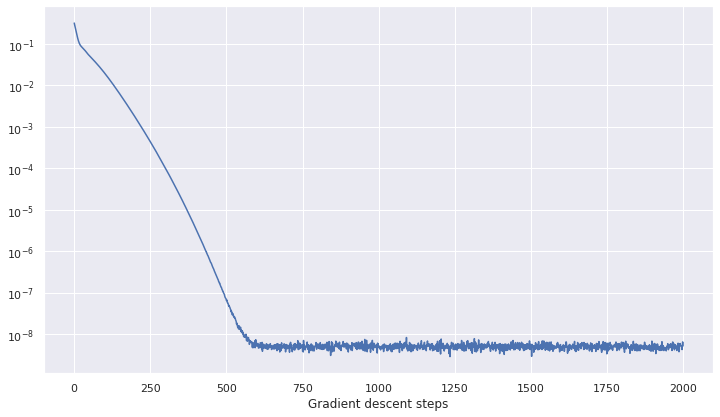

In [13]:
plt.plot(np.abs(loss_epochs_bcMC))
plt.yscale("log")
plt.xlabel("Gradient descent steps")
plt.xlabel("Gradient descent steps")

### Accuracy metrics

Let's compare with the analytical solution and calculate the mean Euler expectation error (EEE):

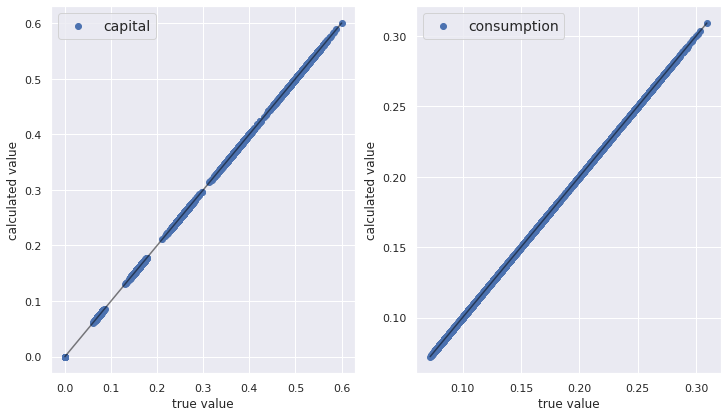

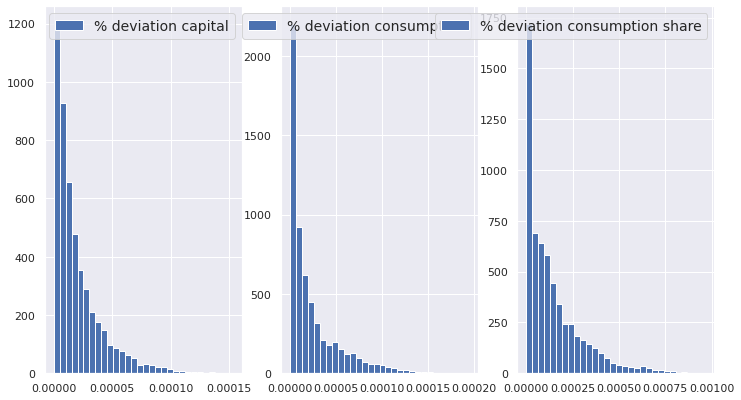

In [14]:
nb_draws = 10 #each draw has params.M draws
with torch.no_grad():
    # Draw nb_draws times M draws from ergodic distribution
    state_vec = generate_n_batches(nb_draws, d_replacement)

    h_matrix = state_vec[:,:-2] #distribution of capital
    # exo states
    tfp_vec = state_vec[:, -2]
    delta_vec = state_vec[:, -1]

    # infer sum of capital
    K_vec = torch.sum(h_matrix, 1)

    ## Exogeneous labour supply. One first period, 0, else
    l_matrix = torch.zeros_like(h_matrix)
    l_matrix[:, 0] = 1
    ## Total labour supply (useless calculations, but then we can generalize the code)
    L_vec = torch.sum(l_matrix, 1)

    ## get factor prices (wages and interest rate)
    r = interest_rate(K_vec, L_vec, delta_vec, tfp_vec, params)
    w = wage(K_vec, L_vec, tfp_vec, params)

    ## calculate wealth, before consumption decision made
    wealth = h_matrix*r.view(-1,1) + l_matrix*w.view(-1,1)

    ## Consumption curent period
    c_vec = model_normalized(model_bcMC, wealth, params)

    ## Infer capital decision
    a_vec = wealth - c_vec
    
a_vec = a_vec.numpy() 
c_vec = c_vec.numpy() 

with torch.no_grad():
    theory_a = wealth*params.mult_wealth.view(1, -1)
    theory_c = wealth - theory_a

theory_a = theory_a.numpy()
theory_c = theory_c.numpy()

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter(theory_a, a_vec, label="capital")
line = np.linspace(np.min(theory_a), np.max(theory_a), 100)
ax1.plot(line, line, color="black", alpha=0.5)
ax1.set_ylabel("calculated value")
ax1.set_xlabel("true value")
ax1.legend()
ax2.scatter(theory_c, c_vec, label="consumption")
line = np.linspace(np.min(theory_c), np.max(theory_c), 100)
ax2.plot(line, line, color="black", alpha=0.5)
ax2.set_ylabel("calculated value")
ax2.set_xlabel("true value")
ax2.legend()
plt.show()

# Plot percentage differences
devs_a = (theory_a[:,:-1] - a_vec[:,:-1])/theory_a[:,:-1] #0 savings last period
devs_a = devs_a

devs_c = (theory_c - c_vec)/theory_c
devs_c = devs_c

with torch.no_grad():
    bound = 1e-6
    ζ0 = torch.sigmoid(model_bcMC(torch.rand(1000, params.dim_input)))
    # Truncate corner solutions
    ζ1 = torch.minimum(torch.maximum(ζ0, torch.tensor([bound])), torch.tensor([1.0 - bound]))
    # Share of cash on hand consumed
    ζ2 = torch.hstack((ζ1, torch.ones(ζ1.shape[0], 1)))

# Difference from theory
diff_shares = ζ2 - (1 - params.mult_wealth)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.hist(np.abs(devs_a.flatten()), bins=30, label="% deviation capital")
ax1.legend()
ax2.hist(np.abs(devs_c.flatten()), bins=30, label="% deviation consumption")
ax2.legend()
ax3.hist(np.abs(diff_shares.flatten()), bins=30, label="% deviation consumption share")
ax3.legend()

In [15]:
for name, devs in zip(["capital", "consumption"], [devs_a, devs_c]):
    abs_dev = 100*np.abs(devs)
    print("Absolute % deviation from true decision for " + name)
    print(f"mean {np.mean(abs_dev )}")
    print(f"max {np.max(abs_dev )}")
    print(f"min {np.min(abs_dev )}")
    print(f"std {np.std(abs_dev )}")
    print(f"P10 {np.quantile(abs_dev, 0.1)}")
    print(f"P90 {np.quantile(abs_dev, 0.9)}")
    
# Euler equation error
EEE_MC = evaluate_accuracy_pytorch_MC(model_bcMC, 1000, 100, params, d_replacement, False)
print(f"Mean Euler equation error (MC): {np.mean(np.abs(EEE_MC))}")

EEE_Gaussian = evaluate_accuracy_pytorch_Gaussian(model_bcMC, 1000, params, d_replacement, False)
print(f"Mean Euler equation error (Gaussian): {np.mean(np.abs(EEE_Gaussian))}")

# Mean loss last 10 observations for the loss
loss_last_episodes = np.mean(loss_epochs_bcMC[-10:].numpy())
print(f"Square root loss function (mean last 10): {(1/params.gamma)*np.sqrt(np.abs(loss_last_episodes))}")

print(f"Square root loss function (last observation): {(1/params.gamma)*np.sqrt(np.abs(loss_epochs_bcMC[-1].numpy()))}")


Absolute % deviation from true decision for capital
mean 0.0020323258358985186
max 0.01529671996831894
min 0.0
std 0.0021564557682722807
P10 0.00020513085619313645
P90 0.004874549387022857
Absolute % deviation from true decision for consumption
mean 0.002367172623053193
max 0.019510917365550995
min 0.0
std 0.002979178912937641
P10 0.0
P90 0.0067072300240397465
Mean Euler equation error (MC): 5.025597783969715e-05
Mean Euler equation error (Gaussian): 4.7686862671980634e-05
Square root loss function (mean last 10): 7.258848927449435e-05
Square root loss function (last observation): 7.170251046773046e-05


### II. E. Jointly solve for policy functions and ergodic distribution

We now **jointly** learn **policy functions** and **the ergodic distribution**.
Below is a description of the algorithm used.

<div style="background-color: #f0f0f0; padding: 10px;">
    
### bc-MC Operator with fixed $N$ and unknown ergodic distribution

**Initialization:**

- Choose ANN architecture (including number of layers, nodes per layer, activation functions) and define loss function using bc-MC operator.
- Initialize ANN parameter vector $\theta$.
- Set number of episodes $E$.
- Set number of gradient descent iterations $G$ per episode.
- Set values for bc-MC hyperparameters $(M, N)$.
- Initialize learning rate $\gamma$ and choose optimization algorithm (e.g., ADAM).

**Episodes Loop:**
    
For $e = 1$ to $E$:
  - Simulate time series using current ANN parameter vector $\theta$. This gives us a current guess for the ergodic distribution of endogeneous variables $\Pi$
    
    **Training Loop, given $\Pi$:**
    
    For $i = 1$ to $G$:
      - Compute decision functions using current ANN parameter vector $\theta$, current guess for ergodic distribution $\Pi$ and hyperparameters $(M, N)$.
      - Compute loss using bc-MC operator.
      - Perform gradient descent step to update ANN parameter vector $\theta$.

**Output:**

- Final trained ANN model.
    
</div>

In [16]:
# Get stats on true ergodic distribution
periods_simul = 10000
## Stochastic simulation
d, d_replacement = generate_data_and_dataloaders_current_model(model_bcMC, params, periods_simul, params.M, use_true_model = True)
# Draw from current ergodic distribution
state_vec = generate_n_batches(nb_draws, d_replacement)
h_matrix = state_vec[:,:-2] 
mean_h_true = torch.mean(h_matrix, axis=0)
std_h_true = torch.std(h_matrix, axis=0)
print(f"Mean capital holding true: {mean_h_true}")
print(f"Stdev. capital holding true: {std_h_true}")
## Non-stochastic SS
d, d_replacement = generate_data_and_dataloaders_current_model(model_bcMC, params, periods_simul, params.M, use_true_model = True, non_stochastic_ss = True)
# Draw from current ergodic distribution
state_vec = generate_n_batches(nb_draws, d_replacement)
h_matrix = state_vec[:,:-2] 
mean_non_stochastic = torch.mean(h_matrix, axis=0)
print(f"Non-stochastic capital holding true: {mean_non_stochastic }")

Mean capital holding true: tensor([0.0000, 0.5070, 0.3701, 0.2553, 0.1583, 0.0744])
Stdev. capital holding true: tensor([0.0000, 0.0252, 0.0180, 0.0117, 0.0073, 0.0035])
Non-stochastic capital holding true: tensor([0.0000, 0.5073, 0.3702, 0.2556, 0.1585, 0.0745])


In [17]:
periods_simul = 10000 #number of simulated periods
nb_draws_summary_stats = 10000 #want to have 1000 draws to calculate summary stats on ergodic distribution
if nb_draws_summary_stats < params.M:
    nb_draws = params.M
else:
    nb_draws = int(nb_draws_summary_stats/params.M)

In [18]:
model_bcMC = NeuralNetwork(params).to(device)
print(model_bcMC)

seed=123
np.random.seed(seed)
torch.manual_seed(seed)

optimizer = create_optimizer(model_bcMC, params.optimizer, params.lr, params.momentum)
# Scheduler
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=params.freq_gamma)
        
num_episodes = 5 #100 #number of times we relcalculate the ergodic distribution 
periods_simul = 10000 #number of simulated periods
nb_draws_summary_stats = 10000 #want to have 1000 draws to calculate summary stats on ergodic distribution
# Get number of batches necessary to get nb_draws_summary_stats observations
if nb_draws_summary_stats < params.M:
    nb_draws = params.M
else:
    nb_draws = int(nb_draws_summary_stats/params.M)
print(f"Number of draws used for summary stats: {nb_draws_summary_stats}") 

# Save summary stats on ergodic distribution
torch_mean_capital_episode = torch.zeros((num_episodes, params.nb_agents))
torch_std_capital_episode = torch.zeros((num_episodes, params.nb_agents))
# To store loss across episodes
loss_bcMC_episode_epoch = torch.zeros((num_episodes, params.nb_epochs))

for episode in tqdm(range(0, num_episodes)):
    # Use current neural net to simulate the economy
    with torch.no_grad():
        model_bcMC.eval() #eval mode for sample generation
        d, d_replacement = generate_data_and_dataloaders_current_model(model_bcMC, params, periods_simul, params.M, use_true_model = False, non_stochastic_ss = False)
        # Draw from current ergodic distribution
        state_vec = generate_n_batches(nb_draws, d_replacement)
        # Summary stats
        ##first elements are distribution of capital. last two columns are exogenous states
        h_matrix = state_vec[:,:-2] 
        torch_mean_capital_episode[episode,: ] = torch.mean(h_matrix, axis=0)
        torch_std_capital_episode[episode,: ] = torch.std(h_matrix, axis=0)
        print(f"----- Episode: {episode} ----------------------")
        per_diff_mean = 100*(torch_mean_capital_episode[episode,: ] - mean_h_true)/mean_h_true
        print(f"% diff Mean capital holding: {per_diff_mean[1:]}")
        #print(f"Mean capital holding true: {mean_h_true}")
        print("-----------------------------------------")
        per_diff_std = 100*(torch_std_capital_episode[episode,: ] - std_h_true)/std_h_true
        print(f"% diff Stdev. capital holding: {per_diff_std[1:]}")
        #print(f"Stdev. capital holding true: {std_h_true}")
    # Training loop, conditional on the sample generate above
    # Optimizer
    model_bcMC.train() #train model
    loss_epochs_bcMC = torch.zeros(params.nb_epochs) #loss current epoch

    for i in range(0, params.nb_epochs):
        # Clear gradient
        optimizer.zero_grad()
        # Calculate loss
        loss = Ξ_torch_MC(model_bcMC, params, d_replacement)
        loss_bcMC_episode_epoch[episode, i] = float(loss.item()) #store loss
        # Backpropagation
        loss.backward()
        # Avoid explosive gradients
        clip_grad_norm_(model_bcMC.parameters(), max_norm=1.0, error_if_nonfinite=False)
        # Gradient descent step
        optimizer.step()

        if i % 1000 == 0:
            loss, current = float(loss.item()), i
            print(f"episode: {episode}/{num_episodes-1}, loss: {loss:>7f}, [{current:>5d}/{params.nb_epochs:>5d}]")
        if (i % params.freq_scheduler == 0) & (i != 0) & (params.use_scheduler == True):
            scheduler.step()
            print("i : {}. Decreasing learning rate: {}".format(i, scheduler.get_last_lr()))

    if params.optimizer == "SWA":
        optimizer.swap_swa_sgd()


NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (act_f): Sigmoid()
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=6, out_features=50, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=50, out_features=5, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=5, out_features=5, bias=True)
  )
)
Number of draws used for summary stats: 10000


  0%|                                                     | 0/5 [00:00<?, ?it/s]

----- Episode: 0 ----------------------
% diff Mean capital holding: tensor([-40.9963, -52.0575, -60.9711, -65.5754, -49.2419])
-----------------------------------------
% diff Stdev. capital holding: tensor([-38.4944, -53.1705, -61.7364, -67.4000, -52.4625])
episode: 0/4, loss: 0.395705, [    0/ 2000]
episode: 0/4, loss: 0.000000, [ 1000/ 2000]


 20%|█████████                                    | 1/5 [00:10<00:43, 10.88s/it]

----- Episode: 1 ----------------------
% diff Mean capital holding: tensor([ 0.0045, -0.0300,  0.1357,  0.1804,  0.1552])
-----------------------------------------
% diff Stdev. capital holding: tensor([ 3.0239,  1.9378,  3.2859,  3.4510, -0.3811])
episode: 1/4, loss: 0.000000, [    0/ 2000]
episode: 1/4, loss: 0.000000, [ 1000/ 2000]


 40%|██████████████████                           | 2/5 [00:21<00:32, 10.83s/it]

----- Episode: 2 ----------------------
% diff Mean capital holding: tensor([0.1713, 0.1360, 0.2430, 0.2613, 0.3305])
-----------------------------------------
% diff Stdev. capital holding: tensor([ 2.6876,  0.4102,  3.1097,  1.1241, -2.0259])
episode: 2/4, loss: 0.000000, [    0/ 2000]
episode: 2/4, loss: 0.000000, [ 1000/ 2000]


 60%|███████████████████████████                  | 3/5 [00:32<00:21, 10.83s/it]

----- Episode: 3 ----------------------
% diff Mean capital holding: tensor([0.0251, 0.0571, 0.2594, 0.1342, 0.1531])
-----------------------------------------
% diff Stdev. capital holding: tensor([ 3.2443,  0.0281,  3.1742,  0.6307, -1.5513])
episode: 3/4, loss: 0.000000, [    0/ 2000]
episode: 3/4, loss: 0.000000, [ 1000/ 2000]


 80%|████████████████████████████████████         | 4/5 [00:43<00:10, 10.84s/it]

----- Episode: 4 ----------------------
% diff Mean capital holding: tensor([0.0391, 0.0077, 0.1620, 0.1281, 0.1117])
-----------------------------------------
% diff Stdev. capital holding: tensor([ 2.5983,  0.3142,  2.4114, -0.1288, -0.4757])
episode: 4/4, loss: 0.000000, [    0/ 2000]
episode: 4/4, loss: 0.000000, [ 1000/ 2000]


100%|█████████████████████████████████████████████| 5/5 [00:54<00:00, 10.84s/it]


Let's visualize the value for the loss function. Vertical lines represent the occurence of a new "episode". 

Text(0.5, 0, 'Number gradient descent steps')

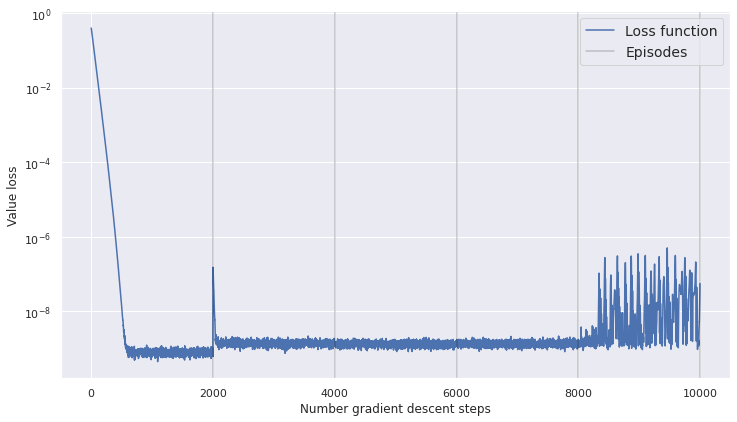

In [19]:
# Plot value loss function
iters = np.arange(1, num_episodes*params.nb_epochs+1)
changes = iters[(iters % params.nb_epochs) == 0]

plt.plot(np.abs(loss_bcMC_episode_epoch.view(-1, 1)), label="Loss function")
for (i, val) in enumerate(changes):
    if i == 0:
        lab="Episodes"
    else:
        lab=""
    plt.axvline(x = val, color="black", alpha=0.2, label=lab)
plt.yscale("log")
plt.legend()
plt.ylabel("Value loss")
plt.xlabel("Number gradient descent steps")

Get an idea of convergence to the ergodic distibution by looking at the mean value of capital holdings per age group.

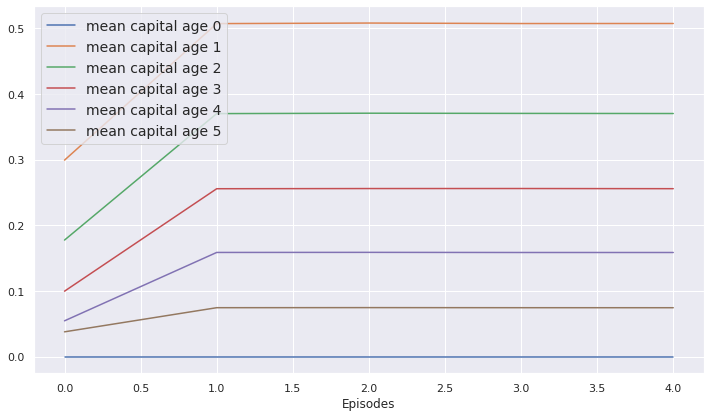

In [20]:
# Illustrate convergence toward the ergodic set
for a in range(0, params.nb_agents):
    plt.plot(torch_mean_capital_episode[:,a], label=f"mean capital age {a}")
plt.xlabel("Episodes")
plt.legend()

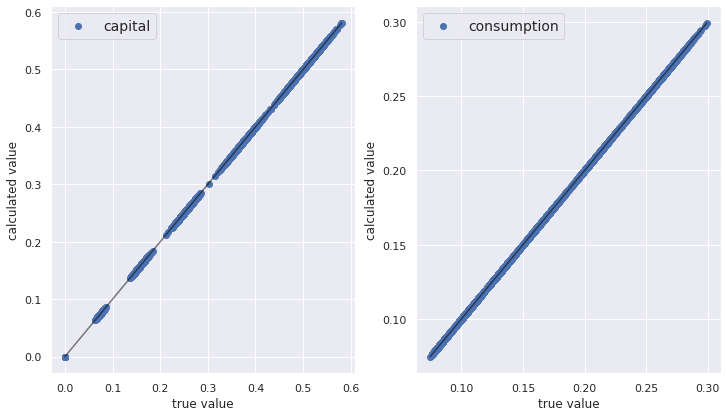

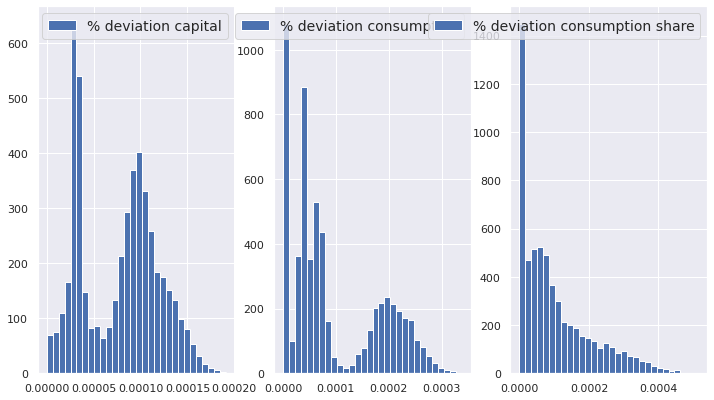

In [21]:
# Acurracy metrics
nb_draws = 10 #each draw has params.M draws
with torch.no_grad():
    # Draw nb_draws times M draws from ergodic distribution
    state_vec = generate_n_batches(nb_draws, d_replacement)

    h_matrix = state_vec[:,:-2] #distribution of capital
    # exo states
    tfp_vec = state_vec[:, -2]
    delta_vec = state_vec[:, -1]

    # infer sum of capital
    K_vec = torch.sum(h_matrix, 1)

    ## Exogeneous labour supply. One first period, 0, else
    l_matrix = torch.zeros_like(h_matrix)
    l_matrix[:, 0] = 1
    ## Total labour supply (useless calculations, but then we can generalize the code)
    L_vec = torch.sum(l_matrix, 1)

    ## get factor prices (wages and interest rate)
    r = interest_rate(K_vec, L_vec, delta_vec, tfp_vec, params)
    w = wage(K_vec, L_vec, tfp_vec, params)

    ## calculate wealth, before consumption decision made
    wealth = h_matrix*r.view(-1,1) + l_matrix*w.view(-1,1)

    ## Consumption curent period
    c_vec = model_normalized(model_bcMC, wealth, params)

    ## Infer capital decision
    a_vec = wealth - c_vec
    
a_vec = a_vec.numpy() 
c_vec = c_vec.numpy() 

with torch.no_grad():
    theory_a = wealth*params.mult_wealth.view(1, -1)
    theory_c = wealth - theory_a

theory_a = theory_a.numpy()
theory_c = theory_c.numpy()

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter(theory_a, a_vec, label="capital")
line = np.linspace(np.min(theory_a), np.max(theory_a), 100)
ax1.plot(line, line, color="black", alpha=0.5)
ax1.set_ylabel("calculated value")
ax1.set_xlabel("true value")
ax1.legend()
ax2.scatter(theory_c, c_vec, label="consumption")
line = np.linspace(np.min(theory_c), np.max(theory_c), 100)
ax2.plot(line, line, color="black", alpha=0.5)
ax2.set_ylabel("calculated value")
ax2.set_xlabel("true value")
ax2.legend()
plt.show()

# Plot percentage differences
devs_a = (theory_a[:,:-1] - a_vec[:,:-1])/theory_a[:,:-1] #0 savings last period
devs_a = devs_a

devs_c = (theory_c - c_vec)/theory_c
devs_c = devs_c

with torch.no_grad():
    bound = 1e-6
    ζ0 = torch.sigmoid(model_bcMC(torch.rand(1000, params.dim_input)))
    # Truncate corner solutions
    ζ1 = torch.minimum(torch.maximum(ζ0, torch.tensor([bound])), torch.tensor([1.0 - bound]))
    # Share of cash on hand consumed
    ζ2 = torch.hstack((ζ1, torch.ones(ζ1.shape[0], 1)))

# Difference from theory
diff_shares = ζ2 - (1 - params.mult_wealth)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.hist(np.abs(devs_a.flatten()), bins=30, label="% deviation capital")
ax1.legend()
ax2.hist(np.abs(devs_c.flatten()), bins=30, label="% deviation consumption")
ax2.legend()
ax3.hist(np.abs(diff_shares.flatten()), bins=30, label="% deviation consumption share")
ax3.legend()

In [22]:
for name, devs in zip(["capital", "consumption"], [devs_a, devs_c]):
    abs_dev = 100*np.abs(devs)
    print("Absolute % deviation from true decision for " + name)
    print(f"mean {np.mean(abs_dev )}")
    print(f"max {np.max(abs_dev )}")
    print(f"min {np.min(abs_dev )}")
    print(f"std {np.std(abs_dev )}")
    print(f"P10 {np.quantile(abs_dev, 0.1)}")
    print(f"P90 {np.quantile(abs_dev, 0.9)}")
    
# Euler equation error
EEE_MC = evaluate_accuracy_pytorch_MC(model_bcMC, 1000, 100, params, d_replacement, False)
print(f"Mean Euler equation error (MC): {np.mean(np.abs(EEE_MC))}")

EEE_Gaussian = evaluate_accuracy_pytorch_Gaussian(model_bcMC, 1000, params, d_replacement, False)
print(f"Mean Euler equation error (Gaussian): {np.mean(np.abs(EEE_Gaussian))}")

# Mean loss last 10 observations for the loss
loss_last_episodes = np.mean(loss_bcMC_episode_epoch[-1, -10:].numpy())
print(f"Square root loss function (mean last 10): {(1/params.gamma)*np.sqrt(np.abs(loss_last_episodes))}")

print(f"Square root loss function last observation: {np.sqrt(np.abs(loss_bcMC_episode_epoch[-1, -1]))}")


Absolute % deviation from true decision for capital
mean 0.0076653016731143
max 0.019078491255640984
min 0.0
std 0.004135954659432173
P10 0.002674765419214964
P90 0.013063572812825441
Absolute % deviation from true decision for consumption
mean 0.009490294381976128
max 0.033828068524599075
min 0.0
std 0.008618529886007309
P10 0.0
P90 0.02282347362488509
Mean Euler equation error (MC): 0.00022199485101737082
Mean Euler equation error (Gaussian): 0.00022279190307017416
Square root loss function (mean last 10): 0.00014106513117440045
Square root loss function last observation: 0.00023607423645444214


### II. F. Optimal selection of N, while jointly solving for policy functions and the ergodic distribution

Let's use the **"N* algorithm"**, which consists in optimal selecting the hyperparameter $N$ during training. As in the previous section, we also jointly learn policy functions and ergodic distribution.

<div style="background-color: #f0f0f0; padding: 10px;">
    
### "N* algorithm": bc-MC Operator with Dynamic Selection of $N^{*}$ and unknown ergodic distribution

**Initialization:**

- Choose ANN architecture (including number of layers, nodes per layer, activation functions) and define loss function using bc-MC operator.
- Initialize ANN parameter vector $\theta$.
- Set number of episodes $E$.
- Set number of gradient descent iterations $G$ per episode.
- Determine initial computational budget $T \equiv \frac{MN}{2}$.
- Initialize hyperparameters $(M, N)$.
- Choose frequency $K$ for hyperparameter update.
- Initialize learning rate $\gamma$ and choose optimization algorithm (e.g., ADAM).

**Episodes Loop:**
    
For $e = 1$ to $E$:
  - Simulate time series using current ANN parameter vector $\theta$. This gives us a current guess for the ergodic distribution of endogeneous variables $\Pi$
   
    **Training Loop, given $\Pi$:**

    For $i = 1$ to $G$:
      - Compute decision functions using current ANN parameter vector $\theta$, current guess for ergodic distribution $\Pi$ and current hyperparameters $(M, N)$.
      - Compute loss using bc-MC operator.
      - Perform gradient descent step to update ANN parameter vector $\theta$.
      - If $i \mod K = 0$: /* _Update $(M, N)$ every $K$ iterations_ */
          - Evaluate variance of loss function using current ANN parameter vector for different values of $(M, N)$, keeping the budget $T$ constant.
          - Dynamically adjust $N$ to $N^{*}$ to minimize variance of loss.
          - Adjust $M$ to $M^{*}$ to keep the budget $T$ constant ($M^{*} = \frac{2T}{N^{*}}$).

**Output:**

- Final trained ANN model.
    
</div>

learning rate: 0.001
nb epochs: 1000
W_expanded.shape: torch.Size([1000, 1000])
M: 100
N: 2
MN: 200
T: 100
optimizer_chosen: Adam
use_scheduler: False
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (act_f): Sigmoid()
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=6, out_features=50, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=50, out_features=5, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=5, out_features=5, bias=True)
  )
)
Mean capital holding true: tensor([0.0000, 0.5076, 0.3708, 0.2554, 0.1586, 0.0743])
Total capital: 1.3667256832122803
Stdev. capital holding true: tensor([0.0000, 0.0246, 0.0181, 0.0125, 0.0072, 0.0034])
Non-stochastic capital holding true: tensor([0.0000, 0.5073, 0.3702, 0.2556, 0.1585, 0.0745])
Total capital: 1.3661555051803589
[  2   4   8  10  20  40  50 100]
[100.  50.  25.  20.  10.   5.   4.   2.]
[200. 200. 200. 200. 200.

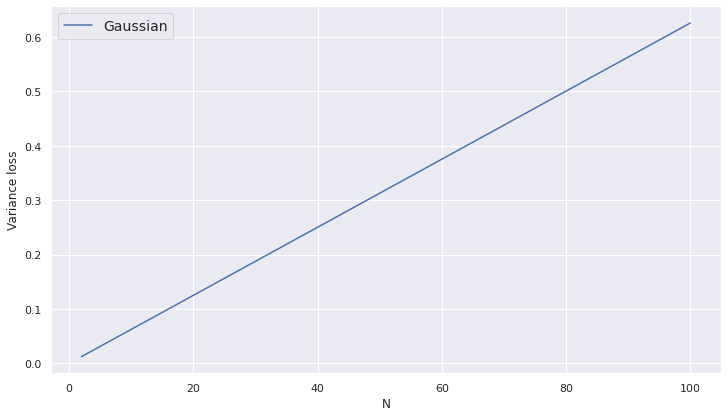

In [23]:
M_chosen = 100 #25 #100 #200 # 50 #outer expectation 
N_chosen = 2 #8 #2 #4 # Inner expectation
lr_chosen = 1e-3 #0.5e-2
nb_epochs_chosen = 1000
order_gauss_chosen = 3
optimizer_chosen = "Adam"
nb_agents_chosen = 6
beta_chosen = 0.7
alpha_chosen = 0.3
std_tfp_chosen = 0.05
std_delta_chosen = 0.01
gamma_chosen = 1.0 #log utility

params = MyParams(N_chosen, M_chosen, lr_chosen, optimizer_chosen, 
                  nb_epochs_chosen, order_gauss_chosen, nb_agents_chosen,
                  beta_chosen, alpha_chosen, std_tfp_chosen, std_delta_chosen, gamma_chosen)

show_params(params)

model_bcMC = NeuralNetwork(params).to(device) #initialize a neural net
print(model_bcMC)

periods_simul = 10000
## Stochastic simulation
d, d_replacement = generate_data_and_dataloaders_current_model(model_bcMC, params, periods_simul, params.M, use_true_model = True)
# Draw from current ergodic distribution
state_vec = generate_n_batches(nb_draws, d_replacement)
h_matrix = state_vec[:,:-2] 
mean_h_true = torch.mean(h_matrix, axis=0)
std_h_true = torch.std(h_matrix, axis=0)
print(f"Mean capital holding true: {mean_h_true}")
print(f"Total capital: {torch.sum(mean_h_true)}")
print(f"Stdev. capital holding true: {std_h_true}")
## Non-stochastic SS
d, d_replacement = generate_data_and_dataloaders_current_model(model_bcMC, params, periods_simul, params.M, use_true_model = True, non_stochastic_ss = True)
# Draw from current ergodic distribution
state_vec = generate_n_batches(nb_draws, d_replacement)
h_matrix = state_vec[:,:-2] 
mean_h_non_stochastic = torch.mean(h_matrix, axis=0)
print(f"Non-stochastic capital holding true: {mean_h_non_stochastic }")
print(f"Total capital: {torch.sum(mean_h_non_stochastic )}")

# Grid M and grid N
T = (params.M*params.N)/2
# Non-evenly spaced grid
grid_N = np.array([N for N in range(2, params.T+2, 2)])
grid_M = 2*T/grid_N

is_int = grid_M % 1 == 0
grid_N = grid_N[is_int]
grid_M = grid_M[is_int]

print(grid_N)
print(grid_M)
print(grid_N*grid_M)

# Pre-calculate params for different choices of M and N
# Used when optimally chosing N during training
list_params = []
for (ind, (N_loop, M_loop)) in enumerate(zip(grid_N, grid_M)):
    # Change M and N
    params_local = MyParams(int(N_loop), int(M_loop), lr_chosen, optimizer_chosen, 
                    nb_epochs_chosen, order_gauss_chosen, nb_agents_chosen, 
                    beta_chosen, alpha_chosen, std_tfp_chosen, std_delta_chosen, gamma_chosen)
    list_params.append(params_local)
    
# Calculate variance of the loss function, given the initial guess for thetha
nb_draws_var = 10000 #10000 #want to have 1000 draws to calculate summary stats on ergodic distribution
variance_loss, var_val, cov_val = calculate_variance_gaussian(params, model_bcMC, nb_draws_var, d_replacement, grid_M, grid_N)
plt.plot(grid_N, variance_loss.detach().numpy(), label="Gaussian")
plt.ylabel("Variance loss")
plt.xlabel("N")
plt.legend()
print(variance_loss)

In [24]:
model_bcMC = NeuralNetwork(params).to(device)
print(model_bcMC)

seed=123
np.random.seed(seed)
torch.manual_seed(seed)

optimizer = create_optimizer(model_bcMC, params.optimizer, params.lr, params.momentum)
# Scheduler
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=params.freq_gamma)
        
num_episodes = 20 #100 #number of times we relcalculate the ergodic distribution 
periods_simul = 10000 #number of simulated periods
nb_draws_summary_stats = 10000 #want to have 1000 draws to calculate summary stats on ergodic distribution
if nb_draws_summary_stats < params.M:
    nb_draws = params.M
else:
    nb_draws = int(nb_draws_summary_stats/params.M)
print(f"Number of draws used for summary stats: {nb_draws_summary_stats}") 

# Save summary stats on ergodic distribution
torch_mean_capital_episode = torch.zeros((num_episodes, params.nb_agents))
torch_std_capital_episode = torch.zeros((num_episodes, params.nb_agents))
# To store loss across episodes
loss_bcMC_episode_epoch = torch.zeros((num_episodes, params.nb_epochs))

list_Euler_median = [] #store median Euler equation error
list_Euler_mean = [] #mean
list_Euler_max = [] #max
list_Euler_std = [] #std
list_Euler_i = [] #store index i
list_Euler_loss = [] #store loss
list_var_loss = [] #store variance of the loss
list_optimal_N = [] #store the optimal N
list_optimal_N_current = [] #store the current optimal N used.
optimal_N = params.N #set initial choice for N
index_best_N = np.where(grid_N == optimal_N)[0][0]
index_best_N_previous = np.where(grid_N == optimal_N)[0][0] #store previous best choice
calculate_variance_loss = True
freq_var =  10 #50 #frequency with which the variance of the loss is calculated
freq_loss = 10 #50 #frequency with which the loss is calculated
ratio_freq_loss_freq_var = int(freq_var/freq_loss)
use_N_star = True #Vary N during training
use_exact_accuracy_metrics = False #True # If False, use square loss to get the EEE
min_euler_bis = float('inf')
best_model = copy.deepcopy(model_bcMC)

for episode in tqdm(range(0, num_episodes)):
    # Use current neural net to simulate the economy
    with torch.no_grad():
        model_bcMC.eval() #eval mode for sample generation
        # Params object associated with the best N
        params_local = list_params[index_best_N]
        # Calculate number of batches necessary to get the right number of observations
        if nb_draws_summary_stats < params_local.M:
            nb_draws = params_local.M
        else:
            nb_draws = int(nb_draws_summary_stats/params_local.M)
        # Generate draws
        use_true_model = False
        non_stochastic_ss = False
        ## Generate dataset
        observations = simulate_current_model(model_bcMC, periods_simul, params_local, use_true_model, non_stochastic_ss)
        ## Build dataloaders
        d, d_replacement = generate_dataloaders(observations, params_local.M)
        # Draw from current ergodic distribution
        state_vec = generate_n_batches(nb_draws, d_replacement)
        # Summary stats
        ##first elements are distribution of capital. last two columns are exogenous states
        h_matrix = state_vec[:,:-2] 
        torch_mean_capital_episode[episode,: ] = torch.mean(h_matrix, axis=0)
        torch_std_capital_episode[episode,: ] = torch.std(h_matrix, axis=0)
        print(f"----- Episode: {episode} ----------------------")
        print(f"Mean capital holding: {torch_mean_capital_episode[episode,1:]}")
        if params.gamma == 1:
            per_diff_mean = 100*(torch_mean_capital_episode[episode,: ] - mean_h_true)/mean_h_true
            print(f"Mean capital holding true: {mean_h_true[1:]}")
            print(f"% diff Mean capital holding: {per_diff_mean[1:]}")
        print("-----------------------------------------")
        print(f"Stdev. capital holding: {torch_std_capital_episode[episode,1: ]}")
        if params.gamma == 1:
            per_diff_std = 100*(torch_std_capital_episode[episode,: ] - std_h_true)/std_h_true
            print(f"Stdev. capital holding true: {std_h_true[1:]}")
            print(f"% diff Stdev. capital holding: {per_diff_std[1:]}")
    # Training loop, conditional on the sample generate above
    # Optimizer
    model_bcMC.train() #train model
    loss_epochs_bcMC = torch.zeros(params.nb_epochs) #loss current epoch

    for i in range(0, params.nb_epochs):
        # Clear gradient
        optimizer.zero_grad()
        # params associated with the current best N:
        params_local = list_params[index_best_N]
        # Update dataloaders
        if index_best_N != index_best_N_previous:
            d, d_replacement = generate_dataloaders(observations, params_local.M)
        # Calculate loss
        loss = Ξ_torch_MC(model_bcMC, params_local, d_replacement)
        loss_bcMC_episode_epoch[episode, i] = float(loss.item()) #store loss
        # Backpropagation
        loss.backward()
        # Avoid explosive gradients
        clip_grad_norm_(model_bcMC.parameters(), max_norm=1.0, error_if_nonfinite=False)
        # Gradient descent step
        optimizer.step()
        ##Monitor accuracy
        if i % freq_loss == 0: 
            model_bcMC.eval()
            list_optimal_N_current.append(optimal_N) #N used
            # Evaluate Euler error
            if use_exact_accuracy_metrics == True:
                error("use_exact_accuracy_metrics True not implement yeat")
            else:
                euler_bis = float(loss.item())**0.5
                list_Euler_mean.append(euler_bis)
            list_Euler_i.append(i) #Index
            list_Euler_loss.append(float(loss.item())) #loss
            model_bcMC.train()
            # Check if current model is better
            mean_euler_bis = np.mean(euler_bis)
            if mean_euler_bis < min_euler_bis:
                min_euler_bis = mean_euler_bis
                best_model = copy.deepcopy(model_bcMC)
        ## Calculation of variance of the loss and optimal choice for N
        if (calculate_variance_loss == True) & (i % freq_var == 0): #calculate variance of loss
            var_loss_formula, var_f, cov_f = calculate_variance_gaussian(params_local, model_bcMC, nb_draws_var, d_replacement, grid_M, grid_N)
            if use_N_star == False:
                index_best_N_dummy = np.argmin(var_loss_formula)
                optimal_N_dummy = grid_N[index_best_N_dummy] #Do not modify optimal_N
                list_optimal_N.append(optimal_N_dummy)
                list_var_loss.append(var_loss_formula[index_best_N])
            # When N* algo is used, update the value of N during training
            else:
                # Store previous best N
                index_best_N_previous = index_best_N
                # Update current best guess using Gaussian formula
                index_best_N = np.argmin(var_loss_formula)
                # Var/Cov
                #N_star_theory = 1 + np.abs(var_f/cov_f)
                #index_best_N = np.argmin(np.abs(N_star_theory - grid_N)) #project on grid
                optimal_N = grid_N[index_best_N]
                list_optimal_N.append(optimal_N)
                list_var_loss.append(var_loss_formula[index_best_N])
        if i % 500 == 0:
            loss, current = float(loss.item()), i
            print(f"episode: {episode}/{num_episodes-1}, N used: {list_optimal_N_current[-1]}, N*: {list_optimal_N[-1]}, loss: {loss:>7f}, [{current:>5d}/{params.nb_epochs:>5d}]")
        if (i % params.freq_scheduler == 0) & (i != 0) & (params.use_scheduler == True):
            scheduler.step()
            print("i : {}. Decreasing learning rate: {}".format(i, scheduler.get_last_lr()))

    if params.optimizer == "SWA":
        optimizer.swap_swa_sgd()


NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (act_f): Sigmoid()
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=6, out_features=50, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=50, out_features=5, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=5, out_features=5, bias=True)
  )
)
Number of draws used for summary stats: 10000


  0%|                                                    | 0/20 [00:00<?, ?it/s]

----- Episode: 0 ----------------------
Mean capital holding: tensor([0.2456, 0.1748, 0.1207, 0.0615, 0.0393])
Mean capital holding true: tensor([0.5076, 0.3708, 0.2554, 0.1586, 0.0743])
% diff Mean capital holding: tensor([-51.6167, -52.8642, -52.7318, -61.2389, -47.0940])
-----------------------------------------
Stdev. capital holding: tensor([0.0127, 0.0084, 0.0055, 0.0027, 0.0017])
Stdev. capital holding true: tensor([0.0246, 0.0181, 0.0125, 0.0072, 0.0034])
% diff Stdev. capital holding: tensor([-48.2438, -53.7815, -56.0088, -62.8000, -49.4465])
episode: 0/19, N used: 2, N*: 2, loss: 0.624317, [    0/ 1000]
episode: 0/19, N used: 2, N*: 2, loss: 0.000282, [  500/ 1000]


  5%|██▏                                         | 1/20 [00:14<04:30, 14.22s/it]

----- Episode: 1 ----------------------
Mean capital holding: tensor([0.5073, 0.3705, 0.2555, 0.1583, 0.0744])
Mean capital holding true: tensor([0.5076, 0.3708, 0.2554, 0.1586, 0.0743])
% diff Mean capital holding: tensor([-0.0700, -0.1047,  0.0552, -0.1753,  0.1124])
-----------------------------------------
Stdev. capital holding: tensor([0.0260, 0.0180, 0.0119, 0.0073, 0.0033])
Stdev. capital holding true: tensor([0.0246, 0.0181, 0.0125, 0.0072, 0.0034])
% diff Stdev. capital holding: tensor([ 5.9567, -0.4829, -4.0580,  0.8996, -1.0698])
episode: 1/19, N used: 2, N*: 2, loss: 0.000000, [    0/ 1000]
episode: 1/19, N used: 2, N*: 2, loss: 0.000000, [  500/ 1000]


 10%|████▍                                       | 2/20 [00:29<04:27, 14.89s/it]

----- Episode: 2 ----------------------
Mean capital holding: tensor([0.5072, 0.3701, 0.2555, 0.1585, 0.0745])
Mean capital holding true: tensor([0.5076, 0.3708, 0.2554, 0.1586, 0.0743])
% diff Mean capital holding: tensor([-0.0850, -0.1946,  0.0690, -0.0451,  0.1767])
-----------------------------------------
Stdev. capital holding: tensor([0.0255, 0.0176, 0.0120, 0.0073, 0.0034])
Stdev. capital holding true: tensor([0.0246, 0.0181, 0.0125, 0.0072, 0.0034])
% diff Stdev. capital holding: tensor([ 3.6318, -2.8533, -3.9115,  0.8974,  0.6833])
episode: 2/19, N used: 2, N*: 2, loss: 0.000000, [    0/ 1000]
episode: 2/19, N used: 2, N*: 2, loss: 0.000000, [  500/ 1000]


 15%|██████▌                                     | 3/20 [00:47<04:39, 16.44s/it]

----- Episode: 3 ----------------------
Mean capital holding: tensor([0.5071, 0.3701, 0.2554, 0.1584, 0.0744])
Mean capital holding true: tensor([0.5076, 0.3708, 0.2554, 0.1586, 0.0743])
% diff Mean capital holding: tensor([-0.1025, -0.2028,  0.0236, -0.1035,  0.1383])
-----------------------------------------
Stdev. capital holding: tensor([0.0259, 0.0176, 0.0122, 0.0074, 0.0034])
Stdev. capital holding true: tensor([0.0246, 0.0181, 0.0125, 0.0072, 0.0034])
% diff Stdev. capital holding: tensor([ 5.1960, -2.9026, -2.2161,  2.2646,  0.7421])
episode: 3/19, N used: 2, N*: 2, loss: 0.000000, [    0/ 1000]
episode: 3/19, N used: 2, N*: 2, loss: 0.000000, [  500/ 1000]


 20%|████████▊                                   | 4/20 [01:02<04:12, 15.76s/it]

----- Episode: 4 ----------------------
Mean capital holding: tensor([0.5068, 0.3700, 0.2552, 0.1584, 0.0744])
Mean capital holding true: tensor([0.5076, 0.3708, 0.2554, 0.1586, 0.0743])
% diff Mean capital holding: tensor([-0.1693, -0.2345, -0.0583, -0.1357,  0.0240])
-----------------------------------------
Stdev. capital holding: tensor([0.0258, 0.0181, 0.0119, 0.0072, 0.0034])
Stdev. capital holding true: tensor([0.0246, 0.0181, 0.0125, 0.0072, 0.0034])
% diff Stdev. capital holding: tensor([ 4.7829, -0.2773, -4.7264,  0.5248, -0.6889])
episode: 4/19, N used: 2, N*: 2, loss: 0.000000, [    0/ 1000]
episode: 4/19, N used: 2, N*: 2, loss: 0.000000, [  500/ 1000]


 25%|███████████                                 | 5/20 [01:16<03:48, 15.25s/it]

----- Episode: 5 ----------------------
Mean capital holding: tensor([0.5082, 0.3706, 0.2561, 0.1588, 0.0746])
Mean capital holding true: tensor([0.5076, 0.3708, 0.2554, 0.1586, 0.0743])
% diff Mean capital holding: tensor([ 0.1203, -0.0729,  0.2902,  0.1600,  0.4138])
-----------------------------------------
Stdev. capital holding: tensor([0.0258, 0.0182, 0.0120, 0.0073, 0.0033])
Stdev. capital holding true: tensor([0.0246, 0.0181, 0.0125, 0.0072, 0.0034])
% diff Stdev. capital holding: tensor([ 4.9802,  0.2288, -3.4915,  1.3021, -1.5388])
episode: 5/19, N used: 2, N*: 2, loss: 0.000000, [    0/ 1000]
episode: 5/19, N used: 2, N*: 2, loss: 0.000000, [  500/ 1000]


 30%|█████████████▏                              | 6/20 [01:30<03:27, 14.83s/it]

----- Episode: 6 ----------------------
Mean capital holding: tensor([0.5071, 0.3705, 0.2559, 0.1585, 0.0746])
Mean capital holding true: tensor([0.5076, 0.3708, 0.2554, 0.1586, 0.0743])
% diff Mean capital holding: tensor([-0.0968, -0.0984,  0.2252, -0.0147,  0.3405])
-----------------------------------------
Stdev. capital holding: tensor([0.0259, 0.0180, 0.0119, 0.0073, 0.0034])
Stdev. capital holding true: tensor([0.0246, 0.0181, 0.0125, 0.0072, 0.0034])
% diff Stdev. capital holding: tensor([ 5.4273, -0.4805, -4.2535,  1.7677,  1.2902])
episode: 6/19, N used: 2, N*: 2, loss: 0.000000, [    0/ 1000]
episode: 6/19, N used: 2, N*: 2, loss: 0.000000, [  500/ 1000]


 35%|███████████████▍                            | 7/20 [01:44<03:09, 14.56s/it]

----- Episode: 7 ----------------------
Mean capital holding: tensor([0.5069, 0.3702, 0.2557, 0.1586, 0.0744])
Mean capital holding true: tensor([0.5076, 0.3708, 0.2554, 0.1586, 0.0743])
% diff Mean capital holding: tensor([-0.1452, -0.1705,  0.1221,  0.0263,  0.1369])
-----------------------------------------
Stdev. capital holding: tensor([0.0256, 0.0182, 0.0120, 0.0074, 0.0034])
Stdev. capital holding true: tensor([0.0246, 0.0181, 0.0125, 0.0072, 0.0034])
% diff Stdev. capital holding: tensor([ 4.0435,  0.4470, -3.5840,  3.2998,  0.2958])
episode: 7/19, N used: 2, N*: 2, loss: 0.000000, [    0/ 1000]
episode: 7/19, N used: 2, N*: 2, loss: 0.000000, [  500/ 1000]


 40%|█████████████████▌                          | 8/20 [01:59<02:54, 14.55s/it]

----- Episode: 8 ----------------------
Mean capital holding: tensor([0.5076, 0.3703, 0.2558, 0.1585, 0.0745])
Mean capital holding true: tensor([0.5076, 0.3708, 0.2554, 0.1586, 0.0743])
% diff Mean capital holding: tensor([-0.0050, -0.1388,  0.1560, -0.0340,  0.2320])
-----------------------------------------
Stdev. capital holding: tensor([0.0257, 0.0181, 0.0120, 0.0074, 0.0034])
Stdev. capital holding true: tensor([0.0246, 0.0181, 0.0125, 0.0072, 0.0034])
% diff Stdev. capital holding: tensor([ 4.6454,  0.0282, -3.4303,  2.6344,  0.8245])
episode: 8/19, N used: 2, N*: 2, loss: 0.000000, [    0/ 1000]
episode: 8/19, N used: 2, N*: 2, loss: 0.000000, [  500/ 1000]


 45%|███████████████████▊                        | 9/20 [02:13<02:38, 14.39s/it]

----- Episode: 9 ----------------------
Mean capital holding: tensor([0.5072, 0.3702, 0.2557, 0.1585, 0.0745])
Mean capital holding true: tensor([0.5076, 0.3708, 0.2554, 0.1586, 0.0743])
% diff Mean capital holding: tensor([-0.0789, -0.1825,  0.1422, -0.0500,  0.1575])
-----------------------------------------
Stdev. capital holding: tensor([0.0260, 0.0181, 0.0122, 0.0074, 0.0034])
Stdev. capital holding true: tensor([0.0246, 0.0181, 0.0125, 0.0072, 0.0034])
% diff Stdev. capital holding: tensor([ 5.7128, -0.0888, -2.0448,  2.6133,  0.6161])
episode: 9/19, N used: 2, N*: 2, loss: 0.000000, [    0/ 1000]
episode: 9/19, N used: 2, N*: 2, loss: 0.000000, [  500/ 1000]


 50%|█████████████████████▌                     | 10/20 [02:27<02:22, 14.27s/it]

----- Episode: 10 ----------------------
Mean capital holding: tensor([0.5084, 0.3709, 0.2559, 0.1588, 0.0747])
Mean capital holding true: tensor([0.5076, 0.3708, 0.2554, 0.1586, 0.0743])
% diff Mean capital holding: tensor([0.1511, 0.0032, 0.2251, 0.1159, 0.4932])
-----------------------------------------
Stdev. capital holding: tensor([0.0263, 0.0180, 0.0119, 0.0073, 0.0034])
Stdev. capital holding true: tensor([0.0246, 0.0181, 0.0125, 0.0072, 0.0034])
% diff Stdev. capital holding: tensor([ 6.9199, -0.3908, -4.2538,  0.9357,  1.6202])
episode: 10/19, N used: 2, N*: 2, loss: 0.000000, [    0/ 1000]
episode: 10/19, N used: 2, N*: 2, loss: 0.000000, [  500/ 1000]


 55%|███████████████████████▋                   | 11/20 [02:41<02:07, 14.19s/it]

----- Episode: 11 ----------------------
Mean capital holding: tensor([0.5075, 0.3702, 0.2558, 0.1586, 0.0744])
Mean capital holding true: tensor([0.5076, 0.3708, 0.2554, 0.1586, 0.0743])
% diff Mean capital holding: tensor([-0.0285, -0.1785,  0.1875, -0.0076,  0.1359])
-----------------------------------------
Stdev. capital holding: tensor([0.0261, 0.0181, 0.0120, 0.0073, 0.0035])
Stdev. capital holding true: tensor([0.0246, 0.0181, 0.0125, 0.0072, 0.0034])
% diff Stdev. capital holding: tensor([ 6.3640,  0.1528, -3.3244,  1.0341,  2.0356])
episode: 11/19, N used: 2, N*: 2, loss: 0.000000, [    0/ 1000]
episode: 11/19, N used: 2, N*: 2, loss: 0.000000, [  500/ 1000]


 60%|█████████████████████████▊                 | 12/20 [02:55<01:53, 14.15s/it]

----- Episode: 12 ----------------------
Mean capital holding: tensor([0.5068, 0.3700, 0.2556, 0.1584, 0.0745])
Mean capital holding true: tensor([0.5076, 0.3708, 0.2554, 0.1586, 0.0743])
% diff Mean capital holding: tensor([-0.1578, -0.2341,  0.0970, -0.0913,  0.1825])
-----------------------------------------
Stdev. capital holding: tensor([0.0260, 0.0179, 0.0120, 0.0073, 0.0034])
Stdev. capital holding true: tensor([0.0246, 0.0181, 0.0125, 0.0072, 0.0034])
% diff Stdev. capital holding: tensor([ 5.5834, -0.9716, -3.7664,  1.8387,  1.6240])
episode: 12/19, N used: 2, N*: 2, loss: 0.000000, [    0/ 1000]
episode: 12/19, N used: 2, N*: 2, loss: 0.000000, [  500/ 1000]


 65%|███████████████████████████▉               | 13/20 [03:10<01:40, 14.33s/it]

----- Episode: 13 ----------------------
Mean capital holding: tensor([0.5072, 0.3700, 0.2555, 0.1585, 0.0744])
Mean capital holding true: tensor([0.5076, 0.3708, 0.2554, 0.1586, 0.0743])
% diff Mean capital holding: tensor([-0.0768, -0.2355,  0.0738, -0.0763,  0.0937])
-----------------------------------------
Stdev. capital holding: tensor([0.0256, 0.0177, 0.0118, 0.0072, 0.0033])
Stdev. capital holding true: tensor([0.0246, 0.0181, 0.0125, 0.0072, 0.0034])
% diff Stdev. capital holding: tensor([ 4.1792, -2.2560, -5.2161,  0.5575, -1.1972])
episode: 13/19, N used: 2, N*: 2, loss: 0.000000, [    0/ 1000]
episode: 13/19, N used: 2, N*: 2, loss: 0.000000, [  500/ 1000]


 70%|██████████████████████████████             | 14/20 [03:24<01:25, 14.21s/it]

----- Episode: 14 ----------------------
Mean capital holding: tensor([0.5074, 0.3701, 0.2554, 0.1584, 0.0745])
Mean capital holding true: tensor([0.5076, 0.3708, 0.2554, 0.1586, 0.0743])
% diff Mean capital holding: tensor([-0.0361, -0.2084,  0.0370, -0.0853,  0.1690])
-----------------------------------------
Stdev. capital holding: tensor([0.0264, 0.0182, 0.0122, 0.0074, 0.0035])
Stdev. capital holding true: tensor([0.0246, 0.0181, 0.0125, 0.0072, 0.0034])
% diff Stdev. capital holding: tensor([ 7.4925,  0.6748, -1.7182,  3.2219,  3.2243])
episode: 14/19, N used: 2, N*: 2, loss: 0.000000, [    0/ 1000]
episode: 14/19, N used: 2, N*: 2, loss: 0.000000, [  500/ 1000]


 75%|████████████████████████████████▎          | 15/20 [03:38<01:10, 14.17s/it]

----- Episode: 15 ----------------------
Mean capital holding: tensor([0.5069, 0.3701, 0.2556, 0.1586, 0.0745])
Mean capital holding true: tensor([0.5076, 0.3708, 0.2554, 0.1586, 0.0743])
% diff Mean capital holding: tensor([-0.1440, -0.1908,  0.1002,  0.0357,  0.1539])
-----------------------------------------
Stdev. capital holding: tensor([0.0259, 0.0181, 0.0120, 0.0074, 0.0034])
Stdev. capital holding true: tensor([0.0246, 0.0181, 0.0125, 0.0072, 0.0034])
% diff Stdev. capital holding: tensor([ 5.2996, -0.2179, -3.2891,  2.5149,  1.3396])
episode: 15/19, N used: 2, N*: 2, loss: 0.000000, [    0/ 1000]
episode: 15/19, N used: 2, N*: 2, loss: 0.000000, [  500/ 1000]


 80%|██████████████████████████████████▍        | 16/20 [03:52<00:56, 14.15s/it]

----- Episode: 16 ----------------------
Mean capital holding: tensor([0.5063, 0.3694, 0.2550, 0.1582, 0.0743])
Mean capital holding true: tensor([0.5076, 0.3708, 0.2554, 0.1586, 0.0743])
% diff Mean capital holding: tensor([-0.2552, -0.3903, -0.1560, -0.2320, -0.0930])
-----------------------------------------
Stdev. capital holding: tensor([0.0255, 0.0180, 0.0119, 0.0072, 0.0034])
Stdev. capital holding true: tensor([0.0246, 0.0181, 0.0125, 0.0072, 0.0034])
% diff Stdev. capital holding: tensor([ 3.8561, -0.5977, -4.6321, -0.3551, -0.7632])
episode: 16/19, N used: 2, N*: 2, loss: 0.000000, [    0/ 1000]
episode: 16/19, N used: 2, N*: 2, loss: 0.000000, [  500/ 1000]


 85%|████████████████████████████████████▌      | 17/20 [04:07<00:43, 14.37s/it]

----- Episode: 17 ----------------------
Mean capital holding: tensor([0.5067, 0.3701, 0.2556, 0.1586, 0.0745])
Mean capital holding true: tensor([0.5076, 0.3708, 0.2554, 0.1586, 0.0743])
% diff Mean capital holding: tensor([-0.1722, -0.1931,  0.1081,  0.0062,  0.2049])
-----------------------------------------
Stdev. capital holding: tensor([0.0261, 0.0186, 0.0123, 0.0075, 0.0034])
Stdev. capital holding true: tensor([0.0246, 0.0181, 0.0125, 0.0072, 0.0034])
% diff Stdev. capital holding: tensor([ 6.3414,  2.5146, -1.2407,  4.1716,  1.5953])
episode: 17/19, N used: 2, N*: 2, loss: 0.000000, [    0/ 1000]
episode: 17/19, N used: 2, N*: 2, loss: 0.000000, [  500/ 1000]


 90%|██████████████████████████████████████▋    | 18/20 [04:21<00:28, 14.25s/it]

----- Episode: 18 ----------------------
Mean capital holding: tensor([0.5069, 0.3700, 0.2557, 0.1584, 0.0745])
Mean capital holding true: tensor([0.5076, 0.3708, 0.2554, 0.1586, 0.0743])
% diff Mean capital holding: tensor([-0.1354, -0.2260,  0.1461, -0.1165,  0.1546])
-----------------------------------------
Stdev. capital holding: tensor([0.0254, 0.0177, 0.0120, 0.0072, 0.0034])
Stdev. capital holding true: tensor([0.0246, 0.0181, 0.0125, 0.0072, 0.0034])
% diff Stdev. capital holding: tensor([ 3.4965, -2.0146, -3.6348,  0.1094,  0.0443])
episode: 18/19, N used: 2, N*: 2, loss: 0.000000, [    0/ 1000]
episode: 18/19, N used: 2, N*: 2, loss: 0.000000, [  500/ 1000]


 95%|████████████████████████████████████████▊  | 19/20 [04:35<00:14, 14.18s/it]

----- Episode: 19 ----------------------
Mean capital holding: tensor([0.5069, 0.3699, 0.2557, 0.1585, 0.0745])
Mean capital holding true: tensor([0.5076, 0.3708, 0.2554, 0.1586, 0.0743])
% diff Mean capital holding: tensor([-0.1396, -0.2444,  0.1231, -0.0450,  0.1854])
-----------------------------------------
Stdev. capital holding: tensor([0.0256, 0.0183, 0.0120, 0.0073, 0.0034])
Stdev. capital holding true: tensor([0.0246, 0.0181, 0.0125, 0.0072, 0.0034])
% diff Stdev. capital holding: tensor([ 4.1932,  1.1929, -3.3113,  1.6761, -0.4336])
episode: 19/19, N used: 2, N*: 2, loss: 0.000000, [    0/ 1000]
episode: 19/19, N used: 2, N*: 2, loss: 0.000000, [  500/ 1000]


100%|███████████████████████████████████████████| 20/20 [04:49<00:00, 14.47s/it]


Text(0.5, 0, 'Number gradient descent steps')

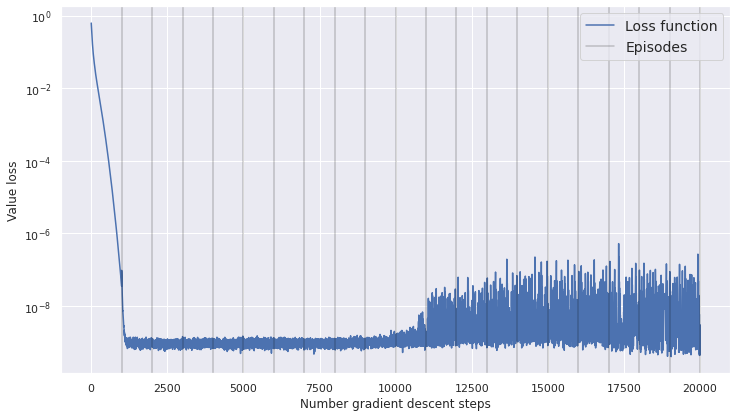

In [25]:
# Plot value loss function
iters = np.arange(1, num_episodes*params.nb_epochs+1)
changes = iters[(iters % params.nb_epochs) == 0]

plt.plot(np.abs(loss_bcMC_episode_epoch.view(-1, 1)), label="Loss function")
for (i, val) in enumerate(changes):
    if i == 0:
        lab="Episodes"
    else:
        lab=""
    plt.axvline(x = val, color="black", alpha=0.2, label=lab)
plt.yscale("log")
plt.legend()
plt.ylabel("Value loss")
plt.xlabel("Number gradient descent steps")

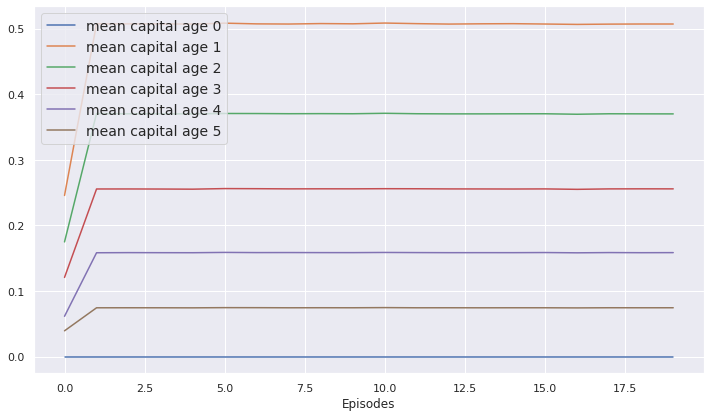

In [26]:
# Convergence towards ergodic set
for a in range(0, params.nb_agents):
    plt.plot(torch_mean_capital_episode[:,a], label=f"mean capital age {a}")
plt.xlabel("Episodes")
plt.legend()

For the analytical model and with this parametrization, it appears that $N^* = 2$.

Text(0.5, 1.0, 'Optimal value for N')

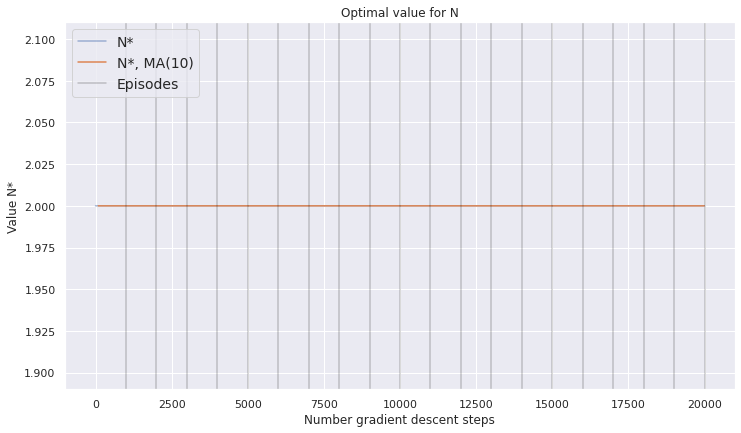

In [27]:
rate = 10
total_iters = loss_bcMC_episode_epoch.shape[0]*loss_bcMC_episode_epoch.shape[1]
x_iters = freq_loss*np.arange(0, int(total_iters/freq_loss)) #saved every freq_loss iterations
plt.plot(x_iters, list_optimal_N_current, label="N*", alpha=0.5)
plt.plot(x_iters, pd.Series(list_optimal_N_current).rolling(rate).mean(), label=f"N*, MA({rate})")
for (i, val) in enumerate(changes):
    if i == 0:
        lab="Episodes"
    else:
        lab=""
    plt.axvline(x = val, color="black", alpha=0.2, label=lab)
plt.legend()
plt.ylabel("Value N*")
plt.xlabel("Number gradient descent steps")
plt.title("Optimal value for N")

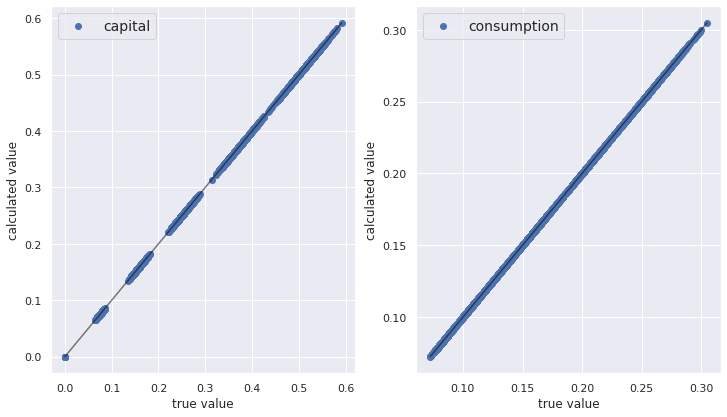

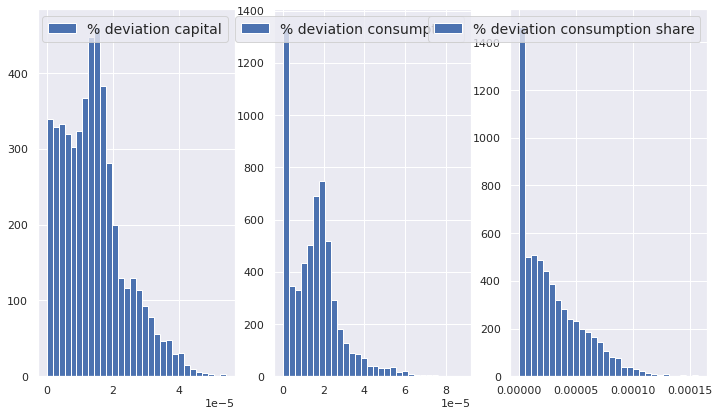

In [28]:
# Acurracy metrics
nb_draws = 10 #each draw has params.M draws
with torch.no_grad():
    # Draw nb_draws times M draws from ergodic distribution
    state_vec = generate_n_batches(nb_draws, d_replacement)

    h_matrix = state_vec[:,:-2] #distribution of capital
    # exo states
    tfp_vec = state_vec[:, -2]
    delta_vec = state_vec[:, -1]

    # infer sum of capital
    K_vec = torch.sum(h_matrix, 1)

    ## Exogeneous labour supply. One first period, 0, else
    l_matrix = torch.zeros_like(h_matrix)
    l_matrix[:, 0] = 1
    ## Total labour supply (useless calculations, but then we can generalize the code)
    L_vec = torch.sum(l_matrix, 1)

    ## get factor prices (wages and interest rate)
    r = interest_rate(K_vec, L_vec, delta_vec, tfp_vec, params)
    w = wage(K_vec, L_vec, tfp_vec, params)

    ## calculate wealth, before consumption decision made
    wealth = h_matrix*r.view(-1,1) + l_matrix*w.view(-1,1)

    ## Consumption curent period
    c_vec = model_normalized(model_bcMC, wealth, params)

    ## Infer capital decision
    a_vec = wealth - c_vec
    
a_vec = a_vec.numpy() 
c_vec = c_vec.numpy() 

with torch.no_grad():
    theory_a = wealth*params.mult_wealth.view(1, -1)
    theory_c = wealth - theory_a

theory_a = theory_a.numpy()
theory_c = theory_c.numpy()

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter(theory_a, a_vec, label="capital")
line = np.linspace(np.min(theory_a), np.max(theory_a), 100)
ax1.plot(line, line, color="black", alpha=0.5)
ax1.set_ylabel("calculated value")
ax1.set_xlabel("true value")
ax1.legend()
ax2.scatter(theory_c, c_vec, label="consumption")
line = np.linspace(np.min(theory_c), np.max(theory_c), 100)
ax2.plot(line, line, color="black", alpha=0.5)
ax2.set_ylabel("calculated value")
ax2.set_xlabel("true value")
ax2.legend()
plt.show()

# Plot percentage differences
devs_a = (theory_a[:,:-1] - a_vec[:,:-1])/theory_a[:,:-1] #0 savings last period
devs_a = devs_a

devs_c = (theory_c - c_vec)/theory_c
devs_c = devs_c

with torch.no_grad():
    bound = 1e-6
    ζ0 = torch.sigmoid(model_bcMC(torch.rand(1000, params.dim_input)))
    # Truncate corner solutions
    ζ1 = torch.minimum(torch.maximum(ζ0, torch.tensor([bound])), torch.tensor([1.0 - bound]))
    # Share of cash on hand consumed
    ζ2 = torch.hstack((ζ1, torch.ones(ζ1.shape[0], 1)))

# Difference from theory
diff_shares = ζ2 - (1 - params.mult_wealth)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.hist(np.abs(devs_a.flatten()), bins=30, label="% deviation capital")
ax1.legend()
ax2.hist(np.abs(devs_c.flatten()), bins=30, label="% deviation consumption")
ax2.legend()
ax3.hist(np.abs(diff_shares.flatten()), bins=30, label="% deviation consumption share")
ax3.legend()

In [29]:
for name, devs in zip(["capital", "consumption"], [devs_a, devs_c]):
    abs_dev = 100*np.abs(devs)
    print("Absolute % deviation from true decision for " + name)
    print(f"mean {np.mean(abs_dev )}")
    print(f"max {np.max(abs_dev )}")
    print(f"min {np.min(abs_dev )}")
    print(f"std {np.std(abs_dev )}")
    print(f"P10 {np.quantile(abs_dev, 0.1)}")
    print(f"P90 {np.quantile(abs_dev, 0.9)}")
    
# Euler equation error
EEE_MC = evaluate_accuracy_pytorch_MC(model_bcMC, 1000, 100, params, d_replacement, False)
print(f"Mean Euler equation error (MC): {np.mean(np.abs(EEE_MC))}")

EEE_Gaussian = evaluate_accuracy_pytorch_Gaussian(model_bcMC, 1000, params, d_replacement, False)
print(f"Mean Euler equation error (Gaussian): {np.mean(np.abs(EEE_Gaussian))}")

# Mean loss last 10 observations for the loss
loss_last_episodes = np.mean(loss_bcMC_episode_epoch[-1, -10:].numpy())
print(f"Square root loss function (mean last 10): {(1/params.gamma)*np.sqrt(np.abs(loss_last_episodes))}")

print(f"Square root loss function last observation: {np.sqrt(np.abs(loss_bcMC_episode_epoch[-1, -1]))}")


Absolute % deviation from true decision for capital
mean 0.001424342393875122
max 0.005429595708847046
min 0.0
std 0.0009496130514889956
P10 0.00026504780980758375
P90 0.002779413643293083
Absolute % deviation from true decision for consumption
mean 0.0015108998632058501
max 0.00880550965666771
min 0.0
std 0.0012764729326590896
P10 0.0
P90 0.002993739978410304
Mean Euler equation error (MC): 4.2094157834071666e-05
Mean Euler equation error (Gaussian): 4.238502879161388e-05
Square root loss function (mean last 10): 4.342788452049717e-05
Square root loss function last observation: 5.376142871682532e-05


### II. G. Optimal selection of N, while jointly solving for policy functions and the ergodic distribution, no analytical solution

Now let's solve the model using $\gamma \neq 1$. In this case, I am not aware of the existence of an analytical solution. However, we can still calculate an approximation of decision functions using the bc-MC operator methodology.

learning rate: 0.001
nb epochs: 1000
W_expanded.shape: torch.Size([1000, 1000])
M: 100
N: 2
MN: 200
T: 100
optimizer_chosen: Adam
use_scheduler: False
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (act_f): Sigmoid()
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=6, out_features=50, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=50, out_features=5, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=5, out_features=5, bias=True)
  )
)
Mean capital holding true: tensor([0.0000, 0.5075, 0.3707, 0.2559, 0.1585, 0.0745])
Total capital: 1.367055058479309
Stdev. capital holding true: tensor([0.0000, 0.0260, 0.0178, 0.0122, 0.0073, 0.0034])
Non-stochastic capital holding true: tensor([0.0000, 0.5073, 0.3702, 0.2556, 0.1585, 0.0745])
Total capital: 1.3661555051803589
[  2   4   8  10  20  40  50 100]
[100.  50.  25.  20.  10.   5.   4.   2.]
[200. 200. 200. 200. 200. 

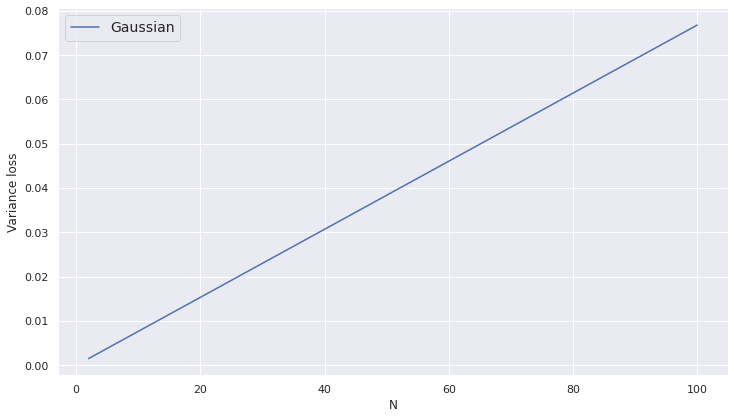

In [30]:
M_chosen = 100 #25 #100 #200 # 50 #outer expectation 
N_chosen = 2 #8 #2 #4 # Inner expectation
lr_chosen = 1e-3 #0.5e-2
nb_epochs_chosen = 1000
order_gauss_chosen = 3
optimizer_chosen = "Adam"
nb_agents_chosen = 6
beta_chosen = 0.7
alpha_chosen = 0.3
std_tfp_chosen = 0.05
std_delta_chosen = 0.01
gamma_chosen = 1.5

params = MyParams(N_chosen, M_chosen, lr_chosen, optimizer_chosen, 
                  nb_epochs_chosen, order_gauss_chosen, nb_agents_chosen,
                  beta_chosen, alpha_chosen, std_tfp_chosen, std_delta_chosen, gamma_chosen)

show_params(params)

model_bcMC = NeuralNetwork(params).to(device) #initialize a neural net
print(model_bcMC)

periods_simul = 10000
## Stochastic simulation
d, d_replacement = generate_data_and_dataloaders_current_model(model_bcMC, params, periods_simul, params.M, use_true_model = True)
# Draw from current ergodic distribution
state_vec = generate_n_batches(nb_draws, d_replacement)
h_matrix = state_vec[:,:-2] 
mean_h_true = torch.mean(h_matrix, axis=0)
std_h_true = torch.std(h_matrix, axis=0)
print(f"Mean capital holding true: {mean_h_true}")
print(f"Total capital: {torch.sum(mean_h_true)}")
print(f"Stdev. capital holding true: {std_h_true}")
## Non-stochastic SS
d, d_replacement = generate_data_and_dataloaders_current_model(model_bcMC, params, periods_simul, params.M, use_true_model = True, non_stochastic_ss = True)
# Draw from current ergodic distribution
state_vec = generate_n_batches(nb_draws, d_replacement)
h_matrix = state_vec[:,:-2] 
mean_h_non_stochastic = torch.mean(h_matrix, axis=0)
print(f"Non-stochastic capital holding true: {mean_h_non_stochastic }")
print(f"Total capital: {torch.sum(mean_h_non_stochastic )}")

# Grid M and grid N
T = (params.M*params.N)/2
# Non-evenly spaced grid
grid_N = np.array([N for N in range(2, params.T+2, 2)])
grid_M = 2*T/grid_N

is_int = grid_M % 1 == 0
grid_N = grid_N[is_int]
grid_M = grid_M[is_int]

print(grid_N)
print(grid_M)
print(grid_N*grid_M)

# Pre-calculate params for different choices of M and N
# Used when optimally chosing N during training
list_params = []
for (ind, (N_loop, M_loop)) in enumerate(zip(grid_N, grid_M)):
    # Change M and N
    params_local = MyParams(int(N_loop), int(M_loop), lr_chosen, optimizer_chosen, 
                    nb_epochs_chosen, order_gauss_chosen, nb_agents_chosen, 
                    beta_chosen, alpha_chosen, std_tfp_chosen, std_delta_chosen, gamma_chosen)
    list_params.append(params_local)
    
# Calculate variance of the loss function, given the initial guess for thetha
nb_draws_var = 10000 #10000 #want to have 1000 draws to calculate summary stats on ergodic distribution
variance_loss, var_val, cov_val = calculate_variance_gaussian(params, model_bcMC, nb_draws_var, d_replacement, grid_M, grid_N)
plt.plot(grid_N, variance_loss.detach().numpy(), label="Gaussian")
plt.ylabel("Variance loss")
plt.xlabel("N")
plt.legend()
print(variance_loss)

In [31]:
model_bcMC = NeuralNetwork(params).to(device)
print(model_bcMC)

seed=123
np.random.seed(seed)
torch.manual_seed(seed)

optimizer = create_optimizer(model_bcMC, params.optimizer, params.lr, params.momentum)
# Scheduler
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=params.freq_gamma)
        
num_episodes = 20 #100 #number of times we relcalculate the ergodic distribution 
periods_simul = 10000 #number of simulated periods
nb_draws_summary_stats = 10000 #want to have 1000 draws to calculate summary stats on ergodic distribution
if nb_draws_summary_stats < params.M:
    nb_draws = params.M
else:
    nb_draws = int(nb_draws_summary_stats/params.M)
print(f"Number of draws used for summary stats: {nb_draws_summary_stats}") 

# Save summary stats on ergodic distribution
torch_mean_capital_episode = torch.zeros((num_episodes, params.nb_agents))
torch_std_capital_episode = torch.zeros((num_episodes, params.nb_agents))
# To store loss across episodes
loss_bcMC_episode_epoch = torch.zeros((num_episodes, params.nb_epochs))

list_Euler_median = [] #store median Euler equation error
list_Euler_mean = [] #mean
list_Euler_max = [] #max
list_Euler_std = [] #std
list_Euler_i = [] #store index i
list_Euler_loss = [] #store loss
list_var_loss = [] #store variance of the loss
list_optimal_N = [] #store the optimal N
list_optimal_N_current = [] #store the current optimal N used.
optimal_N = params.N #set initial choice for N
index_best_N = np.where(grid_N == optimal_N)[0][0]
index_best_N_previous = np.where(grid_N == optimal_N)[0][0] #store previous best choice
calculate_variance_loss = True
freq_var =  10 #50 #frequency with which the variance of the loss is calculated
freq_loss = 10 #50 #frequency with which the loss is calculated
ratio_freq_loss_freq_var = int(freq_var/freq_loss)
use_N_star = True #Vary N during training
use_exact_accuracy_metrics = False #True # If False, use square loss to get the EEE
min_euler_bis = float('inf')
best_model = copy.deepcopy(model_bcMC)

for episode in tqdm(range(0, num_episodes)):
    # Use current neural net to simulate the economy
    with torch.no_grad():
        model_bcMC.eval() #eval mode for sample generation
        # Params object associated with the best N
        params_local = list_params[index_best_N]
        # Calculate number of batches necessary to get the right number of observations
        if nb_draws_summary_stats < params_local.M:
            nb_draws = params_local.M
        else:
            nb_draws = int(nb_draws_summary_stats/params_local.M)
        # Generate draws
        use_true_model = False
        non_stochastic_ss = False
        ## Generate dataset
        observations = simulate_current_model(model_bcMC, periods_simul, params_local, use_true_model, non_stochastic_ss)
        ## Build dataloaders
        d, d_replacement = generate_dataloaders(observations, params_local.M)
        # Draw from current ergodic distribution
        state_vec = generate_n_batches(nb_draws, d_replacement)
        # Summary stats
        ##first elements are distribution of capital. last two columns are exogenous states
        h_matrix = state_vec[:,:-2] 
        torch_mean_capital_episode[episode,: ] = torch.mean(h_matrix, axis=0)
        torch_std_capital_episode[episode,: ] = torch.std(h_matrix, axis=0)
        print(f"----- Episode: {episode} ----------------------")
        print(f"Mean capital holding: {torch_mean_capital_episode[episode,1:]}")
        if params.gamma == 1:
            per_diff_mean = 100*(torch_mean_capital_episode[episode,: ] - mean_h_true)/mean_h_true
            print(f"Mean capital holding true: {mean_h_true[1:]}")
            print(f"% diff Mean capital holding: {per_diff_mean[1:]}")
        print("-----------------------------------------")
        print(f"Stdev. capital holding: {torch_std_capital_episode[episode,1: ]}")
        if params.gamma == 1:
            per_diff_std = 100*(torch_std_capital_episode[episode,: ] - std_h_true)/std_h_true
            print(f"Stdev. capital holding true: {std_h_true[1:]}")
            print(f"% diff Stdev. capital holding: {per_diff_std[1:]}")
    # Training loop, conditional on the sample generate above
    # Optimizer
    model_bcMC.train() #train model
    loss_epochs_bcMC = torch.zeros(params.nb_epochs) #loss current epoch

    for i in range(0, params.nb_epochs):
        # Clear gradient
        optimizer.zero_grad()
        # params associated with the current best N:
        params_local = list_params[index_best_N]
        # Update dataloaders
        if index_best_N != index_best_N_previous:
            d, d_replacement = generate_dataloaders(observations, params_local.M)
        # Calculate loss
        loss = Ξ_torch_MC(model_bcMC, params_local, d_replacement)
        loss_bcMC_episode_epoch[episode, i] = float(loss.item()) #store loss
        # Backpropagation
        loss.backward()
        # Avoid explosive gradients
        clip_grad_norm_(model_bcMC.parameters(), max_norm=1.0, error_if_nonfinite=False)
        # Gradient descent step
        optimizer.step()
        ##Monitor accuracy
        if i % freq_loss == 0: 
            model_bcMC.eval()
            list_optimal_N_current.append(optimal_N) #N used
            # Evaluate Euler error
            if use_exact_accuracy_metrics == True:
                error("use_exact_accuracy_metrics True not implement yeat")
            else:
                euler_bis = float(loss.item())**0.5
                list_Euler_mean.append(euler_bis)
            list_Euler_i.append(i) #Index
            list_Euler_loss.append(float(loss.item())) #loss
            model_bcMC.train()
            # Check if current model is better
            mean_euler_bis = np.mean(euler_bis)
            if mean_euler_bis < min_euler_bis:
                min_euler_bis = mean_euler_bis
                best_model = copy.deepcopy(model_bcMC)
        ## Calculation of variance of the loss and optimal choice for N
        if (calculate_variance_loss == True) & (i % freq_var == 0): #calculate variance of loss
            var_loss_formula, var_f, cov_f = calculate_variance_gaussian(params_local, model_bcMC, nb_draws_var, d_replacement, grid_M, grid_N)
            if use_N_star == False:
                index_best_N_dummy = np.argmin(var_loss_formula)
                optimal_N_dummy = grid_N[index_best_N_dummy] #Do not modify optimal_N
                list_optimal_N.append(optimal_N_dummy)
                list_var_loss.append(var_loss_formula[index_best_N])
            # When N* algo is used, update the value of N during training
            else:
                # Store previous best N
                index_best_N_previous = index_best_N
                # Update current best guess using Gaussian formula
                index_best_N = np.argmin(var_loss_formula)
                # Var/Cov
                #N_star_theory = 1 + np.abs(var_f/cov_f)
                #index_best_N = np.argmin(np.abs(N_star_theory - grid_N)) #project on grid
                optimal_N = grid_N[index_best_N]
                list_optimal_N.append(optimal_N)
                list_var_loss.append(var_loss_formula[index_best_N])
        if i % 500 == 0:
            loss, current = float(loss.item()), i
            print(f"episode: {episode}/{num_episodes-1}, N used: {list_optimal_N_current[-1]}, N*: {list_optimal_N[-1]}, loss: {loss:>7f}, [{current:>5d}/{params.nb_epochs:>5d}]")
        if (i % params.freq_scheduler == 0) & (i != 0) & (params.use_scheduler == True):
            scheduler.step()
            print("i : {}. Decreasing learning rate: {}".format(i, scheduler.get_last_lr()))

    if params.optimizer == "SWA":
        optimizer.swap_swa_sgd()


NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (act_f): Sigmoid()
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=6, out_features=50, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=50, out_features=5, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=5, out_features=5, bias=True)
  )
)
Number of draws used for summary stats: 10000


  0%|                                                    | 0/20 [00:00<?, ?it/s]

----- Episode: 0 ----------------------
Mean capital holding: tensor([0.3249, 0.2854, 0.1902, 0.1203, 0.0681])
-----------------------------------------
Stdev. capital holding: tensor([0.0168, 0.0140, 0.0089, 0.0055, 0.0031])
episode: 0/19, N used: 2, N*: 2, loss: 4.370293, [    0/ 1000]
episode: 0/19, N used: 8, N*: 8, loss: 0.000011, [  500/ 1000]


  5%|██▏                                         | 1/20 [00:15<05:01, 15.88s/it]

----- Episode: 1 ----------------------
Mean capital holding: tensor([0.5544, 0.4169, 0.2960, 0.1879, 0.0902])
-----------------------------------------
Stdev. capital holding: tensor([0.0283, 0.0203, 0.0142, 0.0088, 0.0042])
episode: 1/19, N used: 8, N*: 2, loss: 0.000477, [    0/ 1000]
episode: 1/19, N used: 8, N*: 10, loss: 0.000009, [  500/ 1000]


 10%|████▍                                       | 2/20 [00:32<04:56, 16.45s/it]

----- Episode: 2 ----------------------
Mean capital holding: tensor([0.5642, 0.4271, 0.3046, 0.1949, 0.0940])
-----------------------------------------
Stdev. capital holding: tensor([0.0288, 0.0212, 0.0148, 0.0092, 0.0044])
episode: 2/19, N used: 10, N*: 8, loss: 0.000008, [    0/ 1000]
episode: 2/19, N used: 8, N*: 10, loss: 0.000002, [  500/ 1000]


 15%|██████▌                                     | 3/20 [00:49<04:42, 16.63s/it]

----- Episode: 3 ----------------------
Mean capital holding: tensor([0.5644, 0.4279, 0.3054, 0.1952, 0.0942])
-----------------------------------------
Stdev. capital holding: tensor([0.0289, 0.0209, 0.0145, 0.0091, 0.0043])
episode: 3/19, N used: 8, N*: 10, loss: 0.000007, [    0/ 1000]
episode: 3/19, N used: 10, N*: 10, loss: 0.000007, [  500/ 1000]


 20%|████████▊                                   | 4/20 [01:06<04:29, 16.82s/it]

----- Episode: 4 ----------------------
Mean capital holding: tensor([0.5643, 0.4271, 0.3056, 0.1951, 0.0941])
-----------------------------------------
Stdev. capital holding: tensor([0.0288, 0.0211, 0.0146, 0.0092, 0.0044])
episode: 4/19, N used: 8, N*: 8, loss: 0.000007, [    0/ 1000]
episode: 4/19, N used: 10, N*: 10, loss: 0.000003, [  500/ 1000]


 25%|███████████                                 | 5/20 [01:24<04:18, 17.24s/it]

----- Episode: 5 ----------------------
Mean capital holding: tensor([0.5648, 0.4279, 0.3056, 0.1955, 0.0943])
-----------------------------------------
Stdev. capital holding: tensor([0.0290, 0.0210, 0.0147, 0.0093, 0.0044])
episode: 5/19, N used: 10, N*: 8, loss: 0.000001, [    0/ 1000]
episode: 5/19, N used: 10, N*: 10, loss: 0.000008, [  500/ 1000]


 30%|█████████████▏                              | 6/20 [01:43<04:09, 17.86s/it]

----- Episode: 6 ----------------------
Mean capital holding: tensor([0.5651, 0.4283, 0.3059, 0.1955, 0.0942])
-----------------------------------------
Stdev. capital holding: tensor([0.0290, 0.0211, 0.0146, 0.0092, 0.0044])
episode: 6/19, N used: 10, N*: 8, loss: 0.000000, [    0/ 1000]
episode: 6/19, N used: 8, N*: 10, loss: 0.000009, [  500/ 1000]


 35%|███████████████▍                            | 7/20 [02:04<04:05, 18.92s/it]

----- Episode: 7 ----------------------
Mean capital holding: tensor([0.5655, 0.4289, 0.3068, 0.1960, 0.0946])
-----------------------------------------
Stdev. capital holding: tensor([0.0291, 0.0210, 0.0146, 0.0091, 0.0044])
episode: 7/19, N used: 8, N*: 8, loss: 0.000005, [    0/ 1000]
episode: 7/19, N used: 8, N*: 8, loss: 0.000000, [  500/ 1000]


 40%|█████████████████▌                          | 8/20 [02:22<03:42, 18.52s/it]

----- Episode: 8 ----------------------
Mean capital holding: tensor([0.5654, 0.4283, 0.3061, 0.1958, 0.0943])
-----------------------------------------
Stdev. capital holding: tensor([0.0291, 0.0212, 0.0148, 0.0093, 0.0044])
episode: 8/19, N used: 8, N*: 8, loss: 0.000008, [    0/ 1000]
episode: 8/19, N used: 10, N*: 10, loss: 0.000007, [  500/ 1000]


 45%|███████████████████▊                        | 9/20 [02:39<03:17, 17.96s/it]

----- Episode: 9 ----------------------
Mean capital holding: tensor([0.5638, 0.4271, 0.3052, 0.1949, 0.0941])
-----------------------------------------
Stdev. capital holding: tensor([0.0286, 0.0210, 0.0145, 0.0092, 0.0044])
episode: 9/19, N used: 8, N*: 8, loss: 0.000005, [    0/ 1000]
episode: 9/19, N used: 10, N*: 10, loss: 0.000009, [  500/ 1000]


 50%|█████████████████████▌                     | 10/20 [02:56<02:58, 17.85s/it]

----- Episode: 10 ----------------------
Mean capital holding: tensor([0.5640, 0.4273, 0.3051, 0.1950, 0.0942])
-----------------------------------------
Stdev. capital holding: tensor([0.0294, 0.0212, 0.0147, 0.0092, 0.0044])
episode: 10/19, N used: 10, N*: 10, loss: 0.000004, [    0/ 1000]
episode: 10/19, N used: 10, N*: 10, loss: 0.000005, [  500/ 1000]


 55%|███████████████████████▋                   | 11/20 [03:13<02:38, 17.59s/it]

----- Episode: 11 ----------------------
Mean capital holding: tensor([0.5643, 0.4273, 0.3055, 0.1951, 0.0940])
-----------------------------------------
Stdev. capital holding: tensor([0.0289, 0.0212, 0.0148, 0.0093, 0.0045])
episode: 11/19, N used: 10, N*: 10, loss: 0.000002, [    0/ 1000]
episode: 11/19, N used: 10, N*: 10, loss: -0.000000, [  500/ 1000]


 60%|█████████████████████████▊                 | 12/20 [03:32<02:23, 17.91s/it]

----- Episode: 12 ----------------------
Mean capital holding: tensor([0.5650, 0.4277, 0.3054, 0.1952, 0.0941])
-----------------------------------------
Stdev. capital holding: tensor([0.0284, 0.0208, 0.0146, 0.0091, 0.0044])
episode: 12/19, N used: 8, N*: 10, loss: 0.000004, [    0/ 1000]
episode: 12/19, N used: 10, N*: 20, loss: 0.000000, [  500/ 1000]


 65%|███████████████████████████▉               | 13/20 [03:51<02:07, 18.17s/it]

----- Episode: 13 ----------------------
Mean capital holding: tensor([0.5648, 0.4279, 0.3058, 0.1954, 0.0942])
-----------------------------------------
Stdev. capital holding: tensor([0.0293, 0.0215, 0.0150, 0.0094, 0.0045])
episode: 13/19, N used: 20, N*: 10, loss: 0.000002, [    0/ 1000]
episode: 13/19, N used: 20, N*: 10, loss: 0.000003, [  500/ 1000]


 70%|██████████████████████████████             | 14/20 [04:11<01:53, 18.88s/it]

----- Episode: 14 ----------------------
Mean capital holding: tensor([0.5650, 0.4278, 0.3059, 0.1953, 0.0942])
-----------------------------------------
Stdev. capital holding: tensor([0.0293, 0.0214, 0.0149, 0.0094, 0.0045])
episode: 14/19, N used: 20, N*: 20, loss: 0.000003, [    0/ 1000]
episode: 14/19, N used: 40, N*: 40, loss: 0.000003, [  500/ 1000]


 75%|████████████████████████████████▎          | 15/20 [04:36<01:43, 20.79s/it]

----- Episode: 15 ----------------------
Mean capital holding: tensor([0.5661, 0.4286, 0.3063, 0.1958, 0.0944])
-----------------------------------------
Stdev. capital holding: tensor([0.0297, 0.0215, 0.0150, 0.0092, 0.0045])
episode: 15/19, N used: 20, N*: 50, loss: 0.000001, [    0/ 1000]
episode: 15/19, N used: 40, N*: 100, loss: 0.000001, [  500/ 1000]


 80%|██████████████████████████████████▍        | 16/20 [05:06<01:33, 23.44s/it]

----- Episode: 16 ----------------------
Mean capital holding: tensor([0.5655, 0.4285, 0.3062, 0.1957, 0.0944])
-----------------------------------------
Stdev. capital holding: tensor([0.0296, 0.0214, 0.0149, 0.0094, 0.0045])
episode: 16/19, N used: 100, N*: 40, loss: 0.000000, [    0/ 1000]
episode: 16/19, N used: 20, N*: 40, loss: -0.000000, [  500/ 1000]


 85%|████████████████████████████████████▌      | 17/20 [05:40<01:19, 26.51s/it]

----- Episode: 17 ----------------------
Mean capital holding: tensor([0.5650, 0.4280, 0.3059, 0.1956, 0.0942])
-----------------------------------------
Stdev. capital holding: tensor([0.0295, 0.0213, 0.0151, 0.0094, 0.0045])
episode: 17/19, N used: 50, N*: 50, loss: -0.000000, [    0/ 1000]
episode: 17/19, N used: 100, N*: 100, loss: 0.000001, [  500/ 1000]


 90%|██████████████████████████████████████▋    | 18/20 [06:20<01:01, 30.52s/it]

----- Episode: 18 ----------------------
Mean capital holding: tensor([0.5651, 0.4283, 0.3059, 0.1954, 0.0943])
-----------------------------------------
Stdev. capital holding: tensor([0.0284, 0.0210, 0.0147, 0.0092, 0.0044])
episode: 18/19, N used: 100, N*: 20, loss: 0.000000, [    0/ 1000]
episode: 18/19, N used: 20, N*: 40, loss: 0.000000, [  500/ 1000]


 95%|████████████████████████████████████████▊  | 19/20 [07:01<00:33, 33.85s/it]

----- Episode: 19 ----------------------
Mean capital holding: tensor([0.5663, 0.4293, 0.3067, 0.1961, 0.0946])
-----------------------------------------
Stdev. capital holding: tensor([0.0296, 0.0218, 0.0152, 0.0096, 0.0046])
episode: 19/19, N used: 100, N*: 100, loss: 0.000002, [    0/ 1000]
episode: 19/19, N used: 40, N*: 20, loss: 0.000000, [  500/ 1000]


100%|███████████████████████████████████████████| 20/20 [07:40<00:00, 23.03s/it]


Text(0.5, 0, 'Number gradient descent steps')

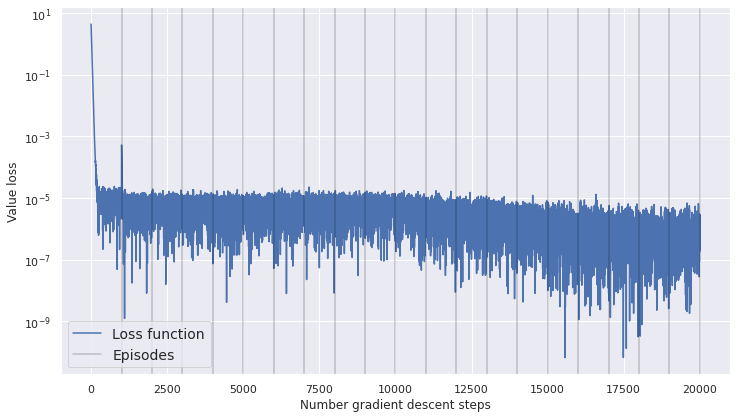

In [32]:
# Plot value loss function
iters = np.arange(1, num_episodes*params.nb_epochs+1)
changes = iters[(iters % params.nb_epochs) == 0]

plt.plot(np.abs(loss_bcMC_episode_epoch.view(-1, 1)), label="Loss function")
for (i, val) in enumerate(changes):
    if i == 0:
        lab="Episodes"
    else:
        lab=""
    plt.axvline(x = val, color="black", alpha=0.2, label=lab)
plt.yscale("log")
plt.legend()
plt.ylabel("Value loss")
plt.xlabel("Number gradient descent steps")

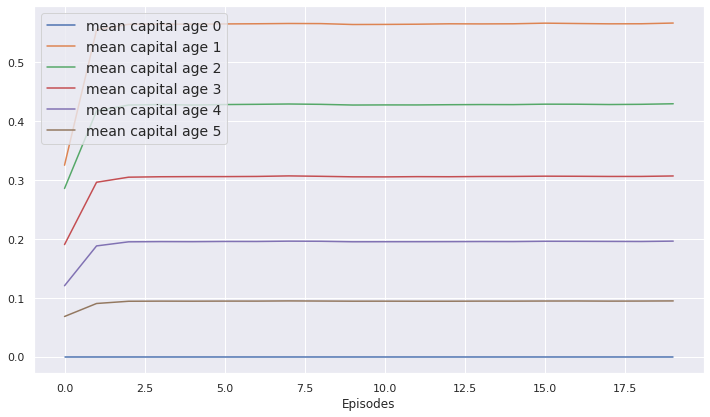

In [33]:
# Convergence towards ergodic set
for a in range(0, params.nb_agents):
    plt.plot(torch_mean_capital_episode[:,a], label=f"mean capital age {a}")
plt.xlabel("Episodes")
plt.legend()

Text(0.5, 1.0, 'Optimal value for N')

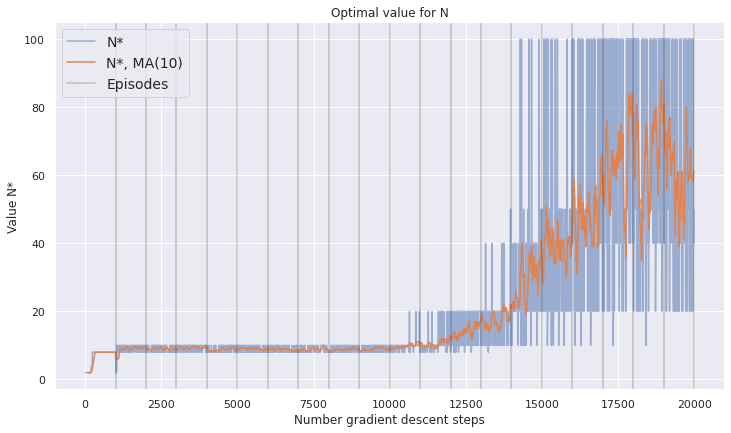

In [34]:
rate = 10
total_iters = loss_bcMC_episode_epoch.shape[0]*loss_bcMC_episode_epoch.shape[1]
x_iters = freq_loss*np.arange(0, int(total_iters/freq_loss)) #saved every freq_loss iterations
plt.plot(x_iters, list_optimal_N_current, label="N*", alpha=0.5)
plt.plot(x_iters, pd.Series(list_optimal_N_current).rolling(rate).mean(), label=f"N*, MA({rate})")
for (i, val) in enumerate(changes):
    if i == 0:
        lab="Episodes"
    else:
        lab=""
    plt.axvline(x = val, color="black", alpha=0.2, label=lab)
plt.legend()
plt.ylabel("Value N*")
plt.xlabel("Number gradient descent steps")
plt.title("Optimal value for N")

Let's compare the solution to the analytical one when $\gamma = 1$.
They should **not** be the same.

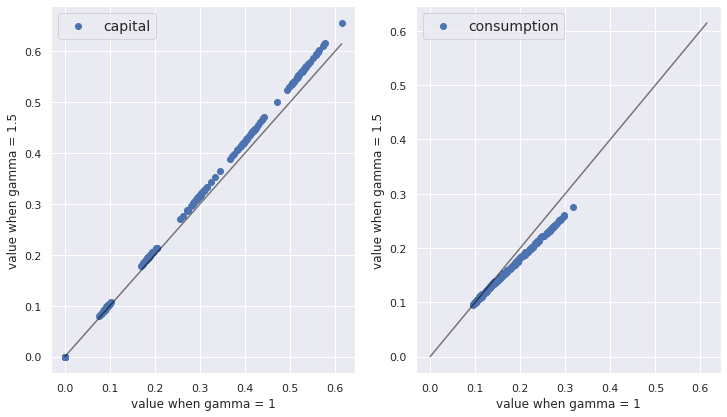

In [35]:
# Compare 
nb_draws = 10 #each draw has params.M draws
with torch.no_grad():
    # Draw nb_draws times M draws from ergodic distribution
    state_vec = generate_n_batches(nb_draws, d_replacement)

    h_matrix = state_vec[:,:-2] #distribution of capital
    # exo states
    tfp_vec = state_vec[:, -2]
    delta_vec = state_vec[:, -1]

    # infer sum of capital
    K_vec = torch.sum(h_matrix, 1)

    ## Exogeneous labour supply. One first period, 0, else
    l_matrix = torch.zeros_like(h_matrix)
    l_matrix[:, 0] = 1
    ## Total labour supply (useless calculations, but then we can generalize the code)
    L_vec = torch.sum(l_matrix, 1)

    ## get factor prices (wages and interest rate)
    r = interest_rate(K_vec, L_vec, delta_vec, tfp_vec, params)
    w = wage(K_vec, L_vec, tfp_vec, params)

    ## calculate wealth, before consumption decision made
    wealth = h_matrix*r.view(-1,1) + l_matrix*w.view(-1,1)

    ## Consumption curent period
    c_vec = model_normalized(model_bcMC, wealth, params)

    ## Infer capital decision
    a_vec = wealth - c_vec
    
a_vec = a_vec.numpy() 
c_vec = c_vec.numpy() 

with torch.no_grad():
    theory_a = wealth*params.mult_wealth.view(1, -1)
    theory_c = wealth - theory_a

theory_a = theory_a.numpy()
theory_c = theory_c.numpy()

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter(theory_a, a_vec, label="capital")
line = np.linspace(np.min(theory_a), np.max(theory_a), 100)
ax1.plot(line, line, color="black", alpha=0.5)
ax1.set_ylabel(f"value when gamma = {params.gamma}")
ax1.set_xlabel("value when gamma = 1")
ax1.legend()
ax2.scatter(theory_c, c_vec, label="consumption")
ax2.plot(line, line, color="black", alpha=0.5)
ax2.set_ylabel(f"value when gamma = {params.gamma}")
ax2.set_xlabel("value when gamma = 1")
ax2.legend()
plt.show()


In [36]:
EEE_MC = evaluate_accuracy_pytorch_MC(model_bcMC, 1000, 100, params_local, d_replacement, False)
print(f"Mean Euler equation error (MC): {np.mean(np.abs(EEE_MC))}")

EEE_Gaussian = evaluate_accuracy_pytorch_Gaussian(model_bcMC, 1000, params_local, d_replacement, False)
print(f"Mean Euler equation error (Gaussian): {np.mean(np.abs(EEE_Gaussian))}")

# Mean loss last 10 observations for the loss
loss_last_episodes = np.mean(loss_bcMC_episode_epoch[-1, -10:].numpy())
print(f"Square root loss function (mean last 10): {(1/params.gamma)*np.sqrt(np.abs(loss_last_episodes))}")

print(f"Square root loss function last observation: {np.sqrt(np.abs(loss_bcMC_episode_epoch[-1, -1]))}")

Mean Euler equation error (MC): 0.0005291503621265292
Mean Euler equation error (Gaussian): 0.00042647315422073007
Square root loss function (mean last 10): 0.0007632961496710777
Square root loss function last observation: 0.001682194648310542


### H. Optimal selection of N, while jointly solving for policy functions and the ergodic distribution, large scale

Let's go back to the model with an alytical solution ($\gamma = 1$). Now let's use **60 age groups** (households between 20 and 80). Let's pretend we do not know the ergodic distribution and use the "N* algorithm".

In only a few minutes of computing time, we get a very accurate solution with 

$$ 100 |\frac{c^{True} - c^{Approx}}{c^{True}}| \approx 2e{-3}$$ 

and 

$$ \mathbf{E}(\mathcal{E}(s)) \approx 8.5e-05$$ 

learning rate: 0.001
nb epochs: 1000
W_expanded.shape: torch.Size([11800, 11800])
M: 100
N: 2
MN: 200
T: 100
optimizer_chosen: Adam
use_scheduler: False
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (act_f): Sigmoid()
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=60, out_features=50, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=50, out_features=5, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=5, out_features=59, bias=True)
  )
)
Mean capital holding true: tensor([0.0000e+00, 6.4240e-01, 4.7662e-01, 3.5298e-01, 2.6160e-01, 1.9437e-01,
        1.4364e-01, 1.0641e-01, 7.8885e-02, 5.8405e-02, 4.3206e-02, 3.2140e-02,
        2.3851e-02, 1.7659e-02, 1.3081e-02, 9.6867e-03, 7.1859e-03, 5.3146e-03,
        3.9458e-03, 2.9253e-03, 2.1650e-03, 1.6067e-03, 1.1864e-03, 8.8058e-04,
        6.5444e-04, 4.8378e-04, 3.5856e-04, 2.6559e-04, 1.9650e-04, 1.4597e-04,
  

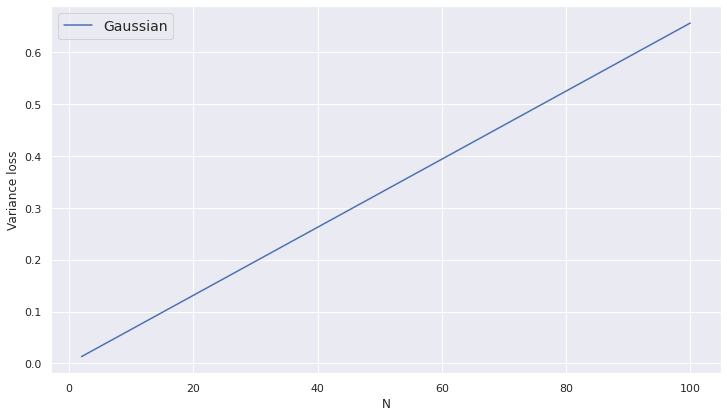

In [37]:
M_chosen = 100 #25 #100 #200 # 50 #outer expectation 
N_chosen = 2 #8 #2 #4 # Inner expectation
lr_chosen = 1e-3 #0.5e-2
nb_epochs_chosen = 1000 #number of epochs per episode
order_gauss_chosen = 3
optimizer_chosen = "Adam"
nb_agents_chosen = 60
beta_chosen = 0.7
alpha_chosen = 0.3
std_tfp_chosen = 0.05
std_delta_chosen = 0.01
gamma_chosen = 1.0 #log utility

params = MyParams(N_chosen, M_chosen, lr_chosen, optimizer_chosen, 
                  nb_epochs_chosen, order_gauss_chosen, nb_agents_chosen,
                  beta_chosen, alpha_chosen, std_tfp_chosen, std_delta_chosen, gamma_chosen)

show_params(params)

model_bcMC = NeuralNetwork(params).to(device) #initialize a neural net
print(model_bcMC)

periods_simul = 10000
## Stochastic simulation
d, d_replacement = generate_data_and_dataloaders_current_model(model_bcMC, params, periods_simul, params.M, use_true_model = True)
# Draw from current ergodic distribution
state_vec = generate_n_batches(nb_draws, d_replacement)
h_matrix = state_vec[:,:-2] 
mean_h_true = torch.mean(h_matrix, axis=0)
std_h_true = torch.std(h_matrix, axis=0)
print(f"Mean capital holding true: {mean_h_true}")
print(f"Total capital: {torch.sum(mean_h_true)}")
print(f"Stdev. capital holding true: {std_h_true}")
## Non-stochastic SS
d, d_replacement = generate_data_and_dataloaders_current_model(model_bcMC, params, periods_simul, params.M, use_true_model = True, non_stochastic_ss = True)
# Draw from current ergodic distribution
state_vec = generate_n_batches(nb_draws, d_replacement)
h_matrix = state_vec[:,:-2] 
mean_h_non_stochastic = torch.mean(h_matrix, axis=0)
print(f"Non-stochastic capital holding true: {mean_h_non_stochastic }")
print(f"Total capital: {torch.sum(mean_h_non_stochastic )}")

# Grid M and grid N
T = (params.M*params.N)/2
# Non-evenly spaced grid
grid_N = np.array([N for N in range(2, params.T+2, 2)])
grid_M = 2*T/grid_N

is_int = grid_M % 1 == 0
grid_N = grid_N[is_int]
grid_M = grid_M[is_int]

print(grid_N)
print(grid_M)
print(grid_N*grid_M)

# Pre-calculate params for different choices of M and N
# Used when optimally chosing N during training
list_params = []
for (ind, (N_loop, M_loop)) in enumerate(zip(grid_N, grid_M)):
    # Change M and N
    params_local = MyParams(int(N_loop), int(M_loop), lr_chosen, optimizer_chosen, 
                    nb_epochs_chosen, order_gauss_chosen, nb_agents_chosen, 
                    beta_chosen, alpha_chosen, std_tfp_chosen, std_delta_chosen, gamma_chosen)
    list_params.append(params_local)
    
# Calculate variance of the loss function, given the initial guess for thetha
nb_draws_var = 10000 #10000 #want to have 1000 draws to calculate summary stats on ergodic distribution
variance_loss, var_val, cov_val = calculate_variance_gaussian(params, model_bcMC, nb_draws_var, d_replacement, grid_M, grid_N)
plt.plot(grid_N, variance_loss.detach().numpy(), label="Gaussian")
plt.ylabel("Variance loss")
plt.xlabel("N")
plt.legend()
print(variance_loss)

In [38]:
model_bcMC = NeuralNetwork(params).to(device)
print(model_bcMC)

seed=123
np.random.seed(seed)
torch.manual_seed(seed)

optimizer = create_optimizer(model_bcMC, params.optimizer, params.lr, params.momentum)
# Scheduler
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=params.freq_gamma)
        
num_episodes = 20 #100 #number of times we relcalculate the ergodic distribution 
periods_simul = 10000 #number of simulated periods
nb_draws_summary_stats = 10000 #want to have 1000 draws to calculate summary stats on ergodic distribution
if nb_draws_summary_stats < params.M:
    nb_draws = params.M
else:
    nb_draws = int(nb_draws_summary_stats/params.M)
print(f"Number of draws used for summary stats: {nb_draws_summary_stats}") 

# Save summary stats on ergodic distribution
torch_mean_capital_episode = torch.zeros((num_episodes, params.nb_agents))
torch_std_capital_episode = torch.zeros((num_episodes, params.nb_agents))
# To store loss across episodes
loss_bcMC_episode_epoch = torch.zeros((num_episodes, params.nb_epochs))

list_Euler_median = [] #store median Euler equation error
list_Euler_mean = [] #mean
list_Euler_max = [] #max
list_Euler_std = [] #std
list_Euler_i = [] #store index i
list_Euler_loss = [] #store loss
list_var_loss = [] #store variance of the loss
list_optimal_N = [] #store the optimal N
list_optimal_N_current = [] #store the current optimal N used.
optimal_N = params.N #set initial choice for N
index_best_N = np.where(grid_N == optimal_N)[0][0]
index_best_N_previous = np.where(grid_N == optimal_N)[0][0] #store previous best choice
calculate_variance_loss = True
freq_var =  10 #50 #frequency with which the variance of the loss is calculated
freq_loss = 10 #50 #frequency with which the loss is calculated
ratio_freq_loss_freq_var = int(freq_var/freq_loss)
use_N_star = True #Vary N during training
use_exact_accuracy_metrics = False #True # If False, use square loss to get the EEE
min_euler_bis = float('inf')
best_model = copy.deepcopy(model_bcMC)

for episode in tqdm(range(0, num_episodes)):
    # Use current neural net to simulate the economy
    with torch.no_grad():
        model_bcMC.eval() #eval mode for sample generation
        # Params object associated with the best N
        params_local = list_params[index_best_N]
        # Calculate number of batches necessary to get the right number of observations
        if nb_draws_summary_stats < params_local.M:
            nb_draws = params_local.M
        else:
            nb_draws = int(nb_draws_summary_stats/params_local.M)
        # Generate draws
        use_true_model = False
        non_stochastic_ss = False
        ## Generate dataset
        observations = simulate_current_model(model_bcMC, periods_simul, params_local, use_true_model, non_stochastic_ss)
        ## Build dataloaders
        d, d_replacement = generate_dataloaders(observations, params_local.M)
        # Draw from current ergodic distribution
        state_vec = generate_n_batches(nb_draws, d_replacement)
        # Summary stats
        ##first elements are distribution of capital. last two columns are exogenous states
        h_matrix = state_vec[:,:-2] 
        torch_mean_capital_episode[episode,: ] = torch.mean(h_matrix, axis=0)
        torch_std_capital_episode[episode,: ] = torch.std(h_matrix, axis=0)
        print(f"----- Episode: {episode} ----------------------")
        #print(f"Mean capital holding: {torch_mean_capital_episode[episode,1:]}")
        if params.gamma == 1:
            per_diff_mean = 100*(torch_mean_capital_episode[episode,: ] - mean_h_true)/mean_h_true
            #print(f"Mean capital holding true: {mean_h_true[1:]}")
            print(f"Max % diff Mean capital holding: {torch.max(per_diff_mean[1:])}")
        print("-----------------------------------------")
        #print(f"Stdev. capital holding: {torch_std_capital_episode[episode,1: ]}")
        if params.gamma == 1:
            per_diff_std = 100*(torch_std_capital_episode[episode,: ] - std_h_true)/std_h_true
            #print(f"Stdev. capital holding true: {std_h_true[1:]}")
            print(f"Max % diff Stdev. capital holding: {torch.max(per_diff_std[1:])}")
    # Training loop, conditional on the sample generate above
    # Optimizer
    model_bcMC.train() #train model
    loss_epochs_bcMC = torch.zeros(params.nb_epochs) #loss current epoch

    for i in range(0, params.nb_epochs):
        # Clear gradient
        optimizer.zero_grad()
        # params associated with the current best N:
        params_local = list_params[index_best_N]
        # Update dataloaders
        if index_best_N != index_best_N_previous:
            d, d_replacement = generate_dataloaders(observations, params_local.M)
        # Calculate loss
        loss = Ξ_torch_MC(model_bcMC, params_local, d_replacement)
        loss_bcMC_episode_epoch[episode, i] = float(loss.item()) #store loss
        # Backpropagation
        loss.backward()
        # Avoid explosive gradients
        clip_grad_norm_(model_bcMC.parameters(), max_norm=1.0, error_if_nonfinite=False)
        # Gradient descent step
        optimizer.step()
        ##Monitor accuracy
        if i % freq_loss == 0: 
            model_bcMC.eval()
            list_optimal_N_current.append(optimal_N) #N used
            # Evaluate Euler error
            if use_exact_accuracy_metrics == True:
                error("use_exact_accuracy_metrics True not implement yeat")
            else:
                euler_bis = float(loss.item())**0.5
                list_Euler_mean.append(euler_bis)
            list_Euler_i.append(i) #Index
            list_Euler_loss.append(float(loss.item())) #loss
            model_bcMC.train()
            # Check if current model is better
            mean_euler_bis = np.mean(euler_bis)
            if mean_euler_bis < min_euler_bis:
                min_euler_bis = mean_euler_bis
                best_model = copy.deepcopy(model_bcMC)
        ## Calculation of variance of the loss and optimal choice for N
        if (calculate_variance_loss == True) & (i % freq_var == 0): #calculate variance of loss
            var_loss_formula, var_f, cov_f = calculate_variance_gaussian(params_local, model_bcMC, nb_draws_var, d_replacement, grid_M, grid_N)
            if use_N_star == False:
                index_best_N_dummy = np.argmin(var_loss_formula)
                optimal_N_dummy = grid_N[index_best_N_dummy] #Do not modify optimal_N
                list_optimal_N.append(optimal_N_dummy)
                list_var_loss.append(var_loss_formula[index_best_N])
            # When N* algo is used, update the value of N during training
            else:
                # Store previous best N
                index_best_N_previous = index_best_N
                # Update current best guess using Gaussian formula
                index_best_N = np.argmin(var_loss_formula)
                # Var/Cov
                #N_star_theory = 1 + np.abs(var_f/cov_f)
                #index_best_N = np.argmin(np.abs(N_star_theory - grid_N)) #project on grid
                optimal_N = grid_N[index_best_N]
                list_optimal_N.append(optimal_N)
                list_var_loss.append(var_loss_formula[index_best_N])
        if i % 500 == 0:
            loss, current = float(loss.item()), i
            print(f"episode: {episode}/{num_episodes-1}, N used: {list_optimal_N_current[-1]}, N*: {list_optimal_N[-1]}, loss: {loss:>7f}, [{current:>5d}/{params.nb_epochs:>5d}]")
        if (i % params.freq_scheduler == 0) & (i != 0) & (params.use_scheduler == True):
            scheduler.step()
            print("i : {}. Decreasing learning rate: {}".format(i, scheduler.get_last_lr()))

    if params.optimizer == "SWA":
        optimizer.swap_swa_sgd()


NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (act_f): Sigmoid()
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=60, out_features=50, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=50, out_features=5, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=5, out_features=59, bias=True)
  )
)
Number of draws used for summary stats: 10000


  0%|                                                    | 0/20 [00:00<?, ?it/s]

----- Episode: 0 ----------------------
Max % diff Mean capital holding: -24.978992462158203
-----------------------------------------
Max % diff Stdev. capital holding: -24.84354591369629
episode: 0/19, N used: 2, N*: 2, loss: 0.963713, [    0/ 1000]
episode: 0/19, N used: 2, N*: 2, loss: 0.060081, [  500/ 1000]


  5%|██▏                                         | 1/20 [00:17<05:28, 17.29s/it]

----- Episode: 1 ----------------------
Max % diff Mean capital holding: -3.773287057876587
-----------------------------------------
Max % diff Stdev. capital holding: -3.0794460773468018
episode: 1/19, N used: 2, N*: 2, loss: 0.002338, [    0/ 1000]
episode: 1/19, N used: 2, N*: 2, loss: 0.000094, [  500/ 1000]


 10%|████▍                                       | 2/20 [00:34<05:12, 17.38s/it]

----- Episode: 2 ----------------------
Max % diff Mean capital holding: 0.8494479656219482
-----------------------------------------
Max % diff Stdev. capital holding: 3.9859628677368164
episode: 2/19, N used: 2, N*: 2, loss: 0.000002, [    0/ 1000]
episode: 2/19, N used: 2, N*: 2, loss: 0.000000, [  500/ 1000]


 15%|██████▌                                     | 3/20 [00:52<04:57, 17.50s/it]

----- Episode: 3 ----------------------
Max % diff Mean capital holding: 0.5245393514633179
-----------------------------------------
Max % diff Stdev. capital holding: 2.4756546020507812
episode: 3/19, N used: 2, N*: 2, loss: 0.000000, [    0/ 1000]
episode: 3/19, N used: 2, N*: 2, loss: 0.000000, [  500/ 1000]


 20%|████████▊                                   | 4/20 [01:10<04:41, 17.62s/it]

----- Episode: 4 ----------------------
Max % diff Mean capital holding: 0.20767147839069366
-----------------------------------------
Max % diff Stdev. capital holding: 3.3184397220611572
episode: 4/19, N used: 2, N*: 2, loss: 0.000000, [    0/ 1000]
episode: 4/19, N used: 2, N*: 2, loss: 0.000000, [  500/ 1000]


 25%|███████████                                 | 5/20 [01:28<04:29, 17.95s/it]

----- Episode: 5 ----------------------
Max % diff Mean capital holding: 1.0901397466659546
-----------------------------------------
Max % diff Stdev. capital holding: 5.399365425109863
episode: 5/19, N used: 2, N*: 2, loss: 0.000000, [    0/ 1000]
episode: 5/19, N used: 2, N*: 2, loss: 0.000000, [  500/ 1000]


 30%|█████████████▏                              | 6/20 [01:46<04:10, 17.87s/it]

----- Episode: 6 ----------------------
Max % diff Mean capital holding: 0.5010895729064941
-----------------------------------------
Max % diff Stdev. capital holding: 2.0940887928009033
episode: 6/19, N used: 2, N*: 2, loss: 0.000000, [    0/ 1000]
episode: 6/19, N used: 2, N*: 2, loss: 0.000000, [  500/ 1000]


 35%|███████████████▍                            | 7/20 [02:03<03:50, 17.76s/it]

----- Episode: 7 ----------------------
Max % diff Mean capital holding: 0.37211182713508606
-----------------------------------------
Max % diff Stdev. capital holding: 4.9364728927612305
episode: 7/19, N used: 2, N*: 2, loss: 0.000000, [    0/ 1000]
episode: 7/19, N used: 2, N*: 2, loss: 0.000000, [  500/ 1000]


 40%|█████████████████▌                          | 8/20 [02:21<03:32, 17.70s/it]

----- Episode: 8 ----------------------
Max % diff Mean capital holding: 0.3830360174179077
-----------------------------------------
Max % diff Stdev. capital holding: 3.539114236831665
episode: 8/19, N used: 2, N*: 2, loss: 0.000000, [    0/ 1000]
episode: 8/19, N used: 2, N*: 2, loss: 0.000000, [  500/ 1000]


 45%|███████████████████▊                        | 9/20 [02:39<03:16, 17.83s/it]

----- Episode: 9 ----------------------
Max % diff Mean capital holding: 0.40226438641548157
-----------------------------------------
Max % diff Stdev. capital holding: 3.676701307296753
episode: 9/19, N used: 2, N*: 2, loss: 0.000000, [    0/ 1000]
episode: 9/19, N used: 2, N*: 2, loss: 0.000000, [  500/ 1000]


 50%|█████████████████████▌                     | 10/20 [02:57<02:56, 17.69s/it]

----- Episode: 10 ----------------------
Max % diff Mean capital holding: 0.5641170144081116
-----------------------------------------
Max % diff Stdev. capital holding: 4.707863807678223
episode: 10/19, N used: 2, N*: 2, loss: 0.000000, [    0/ 1000]
episode: 10/19, N used: 2, N*: 2, loss: 0.000000, [  500/ 1000]


 55%|███████████████████████▋                   | 11/20 [03:14<02:39, 17.74s/it]

----- Episode: 11 ----------------------
Max % diff Mean capital holding: 0.5473774075508118
-----------------------------------------
Max % diff Stdev. capital holding: 3.3248133659362793
episode: 11/19, N used: 2, N*: 2, loss: 0.000000, [    0/ 1000]
episode: 11/19, N used: 2, N*: 2, loss: 0.000000, [  500/ 1000]


 60%|█████████████████████████▊                 | 12/20 [03:32<02:21, 17.72s/it]

----- Episode: 12 ----------------------
Max % diff Mean capital holding: 0.3257681429386139
-----------------------------------------
Max % diff Stdev. capital holding: 3.6912379264831543
episode: 12/19, N used: 2, N*: 2, loss: 0.000000, [    0/ 1000]
episode: 12/19, N used: 2, N*: 2, loss: 0.000000, [  500/ 1000]


 65%|███████████████████████████▉               | 13/20 [03:50<02:04, 17.74s/it]

----- Episode: 13 ----------------------
Max % diff Mean capital holding: 0.38117364048957825
-----------------------------------------
Max % diff Stdev. capital holding: 1.0685771703720093
episode: 13/19, N used: 2, N*: 2, loss: 0.000000, [    0/ 1000]
episode: 13/19, N used: 2, N*: 2, loss: 0.000000, [  500/ 1000]


 70%|██████████████████████████████             | 14/20 [04:09<01:48, 18.06s/it]

----- Episode: 14 ----------------------
Max % diff Mean capital holding: 0.30773937702178955
-----------------------------------------
Max % diff Stdev. capital holding: 4.417581081390381
episode: 14/19, N used: 2, N*: 2, loss: 0.000000, [    0/ 1000]
episode: 14/19, N used: 2, N*: 2, loss: 0.000000, [  500/ 1000]


 75%|████████████████████████████████▎          | 15/20 [04:26<01:29, 17.84s/it]

----- Episode: 15 ----------------------
Max % diff Mean capital holding: 0.40735891461372375
-----------------------------------------
Max % diff Stdev. capital holding: 4.0908002853393555
episode: 15/19, N used: 2, N*: 2, loss: 0.000000, [    0/ 1000]
episode: 15/19, N used: 2, N*: 2, loss: 0.000000, [  500/ 1000]


 80%|██████████████████████████████████▍        | 16/20 [04:44<01:11, 17.79s/it]

----- Episode: 16 ----------------------
Max % diff Mean capital holding: 0.03626001626253128
-----------------------------------------
Max % diff Stdev. capital holding: 2.5589301586151123
episode: 16/19, N used: 2, N*: 2, loss: 0.000000, [    0/ 1000]
episode: 16/19, N used: 2, N*: 2, loss: 0.000000, [  500/ 1000]


 85%|████████████████████████████████████▌      | 17/20 [05:02<00:53, 17.99s/it]

----- Episode: 17 ----------------------
Max % diff Mean capital holding: 0.44077810645103455
-----------------------------------------
Max % diff Stdev. capital holding: 5.182836532592773
episode: 17/19, N used: 2, N*: 2, loss: 0.000000, [    0/ 1000]
episode: 17/19, N used: 2, N*: 2, loss: 0.000000, [  500/ 1000]


 90%|██████████████████████████████████████▋    | 18/20 [05:20<00:36, 18.07s/it]

----- Episode: 18 ----------------------
Max % diff Mean capital holding: 0.7176933884620667
-----------------------------------------
Max % diff Stdev. capital holding: 1.4792367219924927
episode: 18/19, N used: 2, N*: 2, loss: 0.000000, [    0/ 1000]
episode: 18/19, N used: 2, N*: 2, loss: 0.000000, [  500/ 1000]


 95%|████████████████████████████████████████▊  | 19/20 [05:38<00:17, 17.87s/it]

----- Episode: 19 ----------------------
Max % diff Mean capital holding: 0.5684725642204285
-----------------------------------------
Max % diff Stdev. capital holding: 3.7770938873291016
episode: 19/19, N used: 2, N*: 2, loss: 0.000000, [    0/ 1000]
episode: 19/19, N used: 2, N*: 2, loss: 0.000000, [  500/ 1000]


100%|███████████████████████████████████████████| 20/20 [05:57<00:00, 17.87s/it]


Text(0.5, 0, 'Number gradient descent steps')

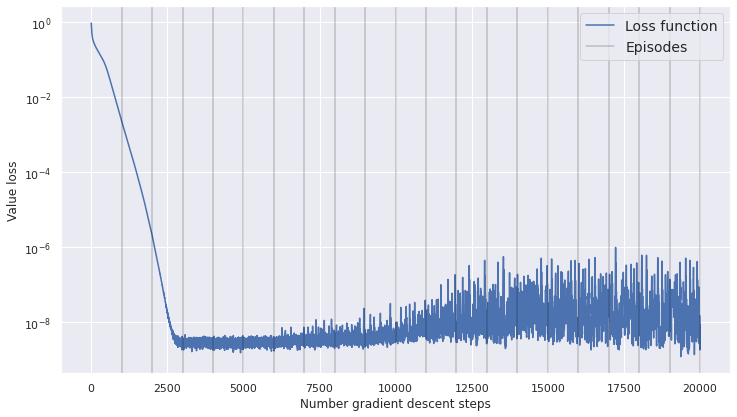

In [39]:
# Plot value loss function
iters = np.arange(1, num_episodes*params.nb_epochs+1)
changes = iters[(iters % params.nb_epochs) == 0]

plt.plot(np.abs(loss_bcMC_episode_epoch.view(-1, 1)), label="Loss function")
for (i, val) in enumerate(changes):
    if i == 0:
        lab="Episodes"
    else:
        lab=""
    plt.axvline(x = val, color="black", alpha=0.2, label=lab)
plt.yscale("log")
plt.legend()
plt.ylabel("Value loss")
plt.xlabel("Number gradient descent steps")

Text(0.5, 0, 'Episodes')

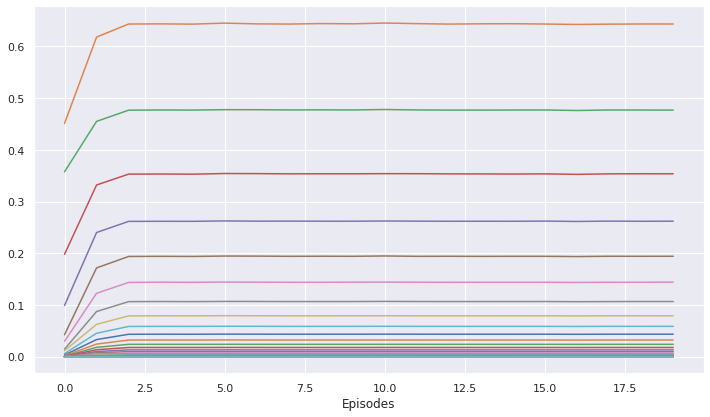

In [40]:
# Convergence towards ergodic set
for a in range(0, params.nb_agents):
    plt.plot(torch_mean_capital_episode[:,a], label=f"mean capital age {a}")
plt.xlabel("Episodes")

Text(0.5, 1.0, 'Optimal value for N')

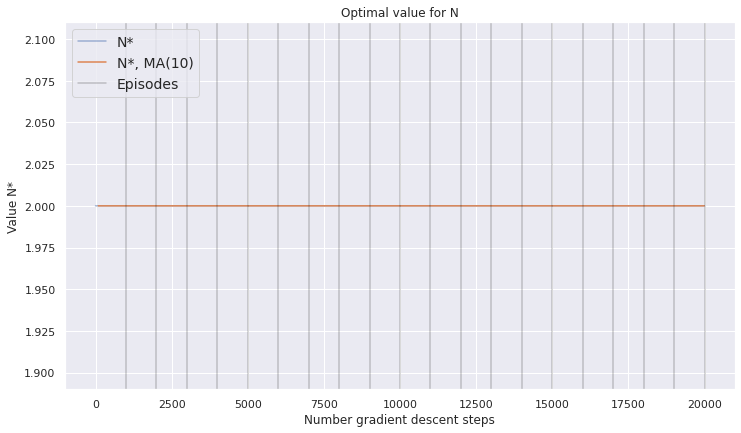

In [41]:
rate = 10
total_iters = loss_bcMC_episode_epoch.shape[0]*loss_bcMC_episode_epoch.shape[1]
x_iters = freq_loss*np.arange(0, int(total_iters/freq_loss)) #saved every freq_loss iterations
plt.plot(x_iters, list_optimal_N_current, label="N*", alpha=0.5)
plt.plot(x_iters, pd.Series(list_optimal_N_current).rolling(rate).mean(), label=f"N*, MA({rate})")
for (i, val) in enumerate(changes):
    if i == 0:
        lab="Episodes"
    else:
        lab=""
    plt.axvline(x = val, color="black", alpha=0.2, label=lab)
plt.legend()
plt.ylabel("Value N*")
plt.xlabel("Number gradient descent steps")
plt.title("Optimal value for N")

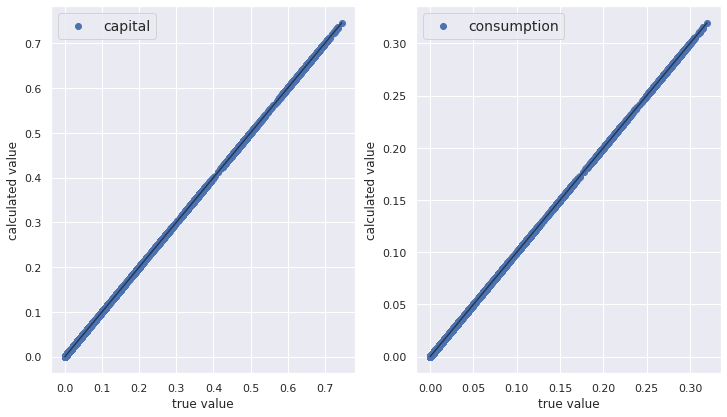

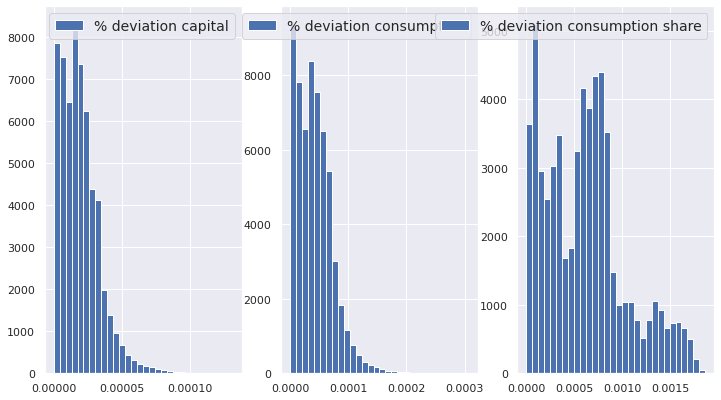

In [42]:
# Acurracy metrics
nb_draws = 10 #each draw has params.M draws
with torch.no_grad():
    # Draw nb_draws times M draws from ergodic distribution
    state_vec = generate_n_batches(nb_draws, d_replacement)

    h_matrix = state_vec[:,:-2] #distribution of capital
    # exo states
    tfp_vec = state_vec[:, -2]
    delta_vec = state_vec[:, -1]

    # infer sum of capital
    K_vec = torch.sum(h_matrix, 1)

    ## Exogeneous labour supply. One first period, 0, else
    l_matrix = torch.zeros_like(h_matrix)
    l_matrix[:, 0] = 1
    ## Total labour supply (useless calculations, but then we can generalize the code)
    L_vec = torch.sum(l_matrix, 1)

    ## get factor prices (wages and interest rate)
    r = interest_rate(K_vec, L_vec, delta_vec, tfp_vec, params)
    w = wage(K_vec, L_vec, tfp_vec, params)

    ## calculate wealth, before consumption decision made
    wealth = h_matrix*r.view(-1,1) + l_matrix*w.view(-1,1)

    ## Consumption curent period
    c_vec = model_normalized(model_bcMC, wealth, params)

    ## Infer capital decision
    a_vec = wealth - c_vec
    
a_vec = a_vec.numpy() 
c_vec = c_vec.numpy() 

with torch.no_grad():
    theory_a = wealth*params.mult_wealth.view(1, -1)
    theory_c = wealth - theory_a

theory_a = theory_a.numpy()
theory_c = theory_c.numpy()

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter(theory_a, a_vec, label="capital")
line = np.linspace(np.min(theory_a), np.max(theory_a), 100)
ax1.plot(line, line, color="black", alpha=0.5)
ax1.set_ylabel("calculated value")
ax1.set_xlabel("true value")
ax1.legend()
ax2.scatter(theory_c, c_vec, label="consumption")
line = np.linspace(np.min(theory_c), np.max(theory_c), 100)
ax2.plot(line, line, color="black", alpha=0.5)
ax2.set_ylabel("calculated value")
ax2.set_xlabel("true value")
ax2.legend()
plt.show()

# Plot percentage differences
devs_a = (theory_a[:,:-1] - a_vec[:,:-1])/theory_a[:,:-1] #0 savings last period
devs_a = devs_a

devs_c = (theory_c - c_vec)/theory_c
devs_c = devs_c

with torch.no_grad():
    bound = 1e-6
    ζ0 = torch.sigmoid(model_bcMC(torch.rand(1000, params.dim_input)))
    # Truncate corner solutions
    ζ1 = torch.minimum(torch.maximum(ζ0, torch.tensor([bound])), torch.tensor([1.0 - bound]))
    # Share of cash on hand consumed
    ζ2 = torch.hstack((ζ1, torch.ones(ζ1.shape[0], 1)))

# Difference from theory
diff_shares = ζ2 - (1 - params.mult_wealth)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.hist(np.abs(devs_a.flatten()), bins=30, label="% deviation capital")
ax1.legend()
ax2.hist(np.abs(devs_c.flatten()), bins=30, label="% deviation consumption")
ax2.legend()
ax3.hist(np.abs(diff_shares.flatten()), bins=30, label="% deviation consumption share")
ax3.legend()

In [43]:
for name, devs in zip(["capital", "consumption"], [devs_a, devs_c]):
    abs_dev = 100*np.abs(devs)
    print("Absolute % deviation from true decision for " + name)
    print(f"mean {np.mean(abs_dev )}")
    print(f"max {np.max(abs_dev )}")
    print(f"min {np.min(abs_dev )}")
    print(f"std {np.std(abs_dev )}")
    print(f"P10 {np.quantile(abs_dev, 0.1)}")
    print(f"P90 {np.quantile(abs_dev, 0.9)}")

Absolute % deviation from true decision for capital
mean 0.0019347949419170618
max 0.0131766889244318
min 0.0
std 0.0014337216271087527
P10 0.0003249659173889086
P90 0.00366493440233171
Absolute % deviation from true decision for consumption
mean 0.004183220211416483
max 0.030752580612897873
min 0.0
std 0.0030671546701341867
P10 0.000593753409339115
P90 0.00794268436729908


In [46]:
EEE_MC = evaluate_accuracy_pytorch_MC(model_bcMC, 1000, 100, params_local, d_replacement, False)
print(f"Mean Euler equation error (MC): {np.mean(np.abs(EEE_MC))}")

EEE_Gaussian = evaluate_accuracy_pytorch_Gaussian(model_bcMC, 1000, params_local, d_replacement, False)
print(f"Mean Euler equation error (Gaussian): {np.mean(np.abs(EEE_Gaussian))}")

# Mean loss last 10 observations for the loss
loss_last_episodes = np.mean(loss_bcMC_episode_epoch[-1, -10:].numpy())
print(f"Square root loss function (mean last 10): {(1/params.gamma)*np.sqrt(np.abs(loss_last_episodes))}")

print(f"Square root loss function (last observation): {(1/params.gamma)*np.sqrt(np.abs(loss_bcMC_episode_epoch[-1, -1]))}")


Mean Euler equation error (MC): 8.585666364524513e-05
Mean Euler equation error (Gaussian): 8.567317854613066e-05
Square root loss function (mean last 10): 7.12787004886195e-05
Square root loss function (last observation): 9.319949458586052e-05


---

## Hardware details

In [47]:
!python3 --version

Python 3.8.10


In [48]:
cpuinfo.get_cpu_info()

{'python_version': '3.8.10.final.0 (64 bit)',
 'cpuinfo_version': [9, 0, 0],
 'cpuinfo_version_string': '9.0.0',
 'arch': 'X86_64',
 'bits': 64,
 'count': 12,
 'arch_string_raw': 'x86_64',
 'vendor_id_raw': 'GenuineIntel',
 'brand_raw': 'Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz',
 'hz_advertised_friendly': '2.6000 GHz',
 'hz_actual_friendly': '4.0810 GHz',
 'hz_advertised': [2600000000, 0],
 'hz_actual': [4080974000, 0],
 'stepping': 10,
 'model': 158,
 'family': 6,
 'flags': ['3dnowprefetch',
  'abm',
  'acpi',
  'adx',
  'aes',
  'aperfmperf',
  'apic',
  'arat',
  'arch_capabilities',
  'arch_perfmon',
  'art',
  'avx',
  'avx2',
  'bmi1',
  'bmi2',
  'bts',
  'clflush',
  'clflushopt',
  'cmov',
  'constant_tsc',
  'cpuid',
  'cpuid_fault',
  'cx16',
  'cx8',
  'de',
  'ds_cpl',
  'dtes64',
  'dtherm',
  'dts',
  'epb',
  'ept',
  'ept_ad',
  'erms',
  'est',
  'f16c',
  'flexpriority',
  'flush_l1d',
  'fma',
  'fpu',
  'fsgsbase',
  'fxsr',
  'hle',
  'ht',
  'hwp',
  'hwp_act_wi

---

## References

* Azinovic, Marlon, Luca Gaegauf, and Simon Scheidegger. "Deep equilibrium nets." International Economic Review 63.4 (2022): 1471-1525.

* Huffman, Gregory W. "A dynamic equilibrium model of asset prices and transaction volume." Journal of Political Economy 95.1 (1987): 138-159.

* Krueger, Dirk, and Felix Kubler. "Computing equilibrium in OLG models with stochastic production." Journal of Economic Dynamics and Control 28.7 (2004): 1411-1436.

*  Pascal, Julien, Artificial Neural Networks to Solve Dynamic Programming Problems: A Bias-Corrected Monte Carlo Operator (January 16, 2024). BCL Working Papers n°172, Available at SSRN: https://ssrn.com/abstract=4476122 or http://dx.doi.org/10.2139/ssrn.4476122 